In [1]:
# Load libraries

# # Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import matplotlib as matplotlib
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.dates import DateFormatter
import matplotlib.animation as animation
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util


# import seaborn as sns

# Analysis
import time
import numpy as np 
import xarray as xr
import datetime
from   datetime import date, timedelta
import pandas as pd 
import pickle
import scipy.stats as stats
import glob
import os 

import metpy.calc as mpc
from metpy.units import units
from metpy.plots import Hodograph, SkewT

import warnings
warnings.filterwarnings('ignore')

## Import Ngl with pyn_env active 
import Ngl



In [2]:
# Grabbed from Brian M. to use time midpoints, not end periods
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds


In [3]:
def interpolateToPressure_v2(DS, varName, pressGoals):
#     nCases = len(DSin.case.values)
#     nTimes = len(DSin.time.values)
    
#     saveOut = np.full([nTimes,len(pressGoals),1,1], np.nan)

    ## For the larger arrays, need to operate case-by-case; input to vinth2p can only be 3 or 4 dimensions. 
#     for iCase in range(nCases): 
#     DS = DSin

    p0mb = DS.P0.values/100        # mb

    # Pull out hya/hyb profiles 
    hyam = DS.hyam.values
    hybm = DS.hybm.values
    hyai = DS.hyai.values
    hybi = DS.hybi.values

    # Surface pressure with time dimension
    PS   = DS.PS.values              # Pa 

    # Converting variables: 
    if np.shape(DS[varName].values)[1]==len(DS.ilev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyai,hybi,pressGoals,PS,1,p0mb,1,True)
    elif np.shape(DS[varName].values)[1]==len(DS.lev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyam,hybm,pressGoals,PS,1,p0mb,1,True)

    saveOut = varInterp
    
    return saveOut


## Grab SCAM data

In [5]:
## Extra vars I want, but they're on the h0 files instead of the h1 files (same time step, just different stream) 
addVars = np.asarray(['SWCF','LWCF','TS','CLOUD','FSNS','FLNS','PS','QREFHT',
                      'U10','CLDHGH','CLDLIQ','TMQ'])

In [6]:
archiveDir = '/glade/scratch/mdfowler/archive/'

dateString = '0609' ## V3 or multiplier test 
# dateString = '0923'   ## V4 for the multiplier tests 
# dateString = '0715'   ## V2 for multiplier tests 

case_mult = ['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMGens2016_start'+dateString+'_pert00/',
             'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTGens2016_start'+dateString+'_pert00/',
             'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTGens2016_mult5_start'+dateString+'_pert00/', 
             'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTGens2016_mult10_start'+dateString+'_pert00/',
             # 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_LESmultipliers_start'+dateString+'2017/',    #LES-based multipliers
             'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_LESmultipliersV3_start'+dateString+'2016/',    #LES-based multipliers
             'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_LESmultipliersV3_c7eq0p75_start'+dateString+'2016/',    #C7 + LES-based multipliers
             # 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTGens2016_mult100_start'+dateString+'_pert00/',
            ]


# caseMult_names = ['HMG','HTG*01','HTG*05','HTG*10','HTG*LESvals','HTG*LESvals_c7eq0p75','HTG*100']
caseMult_names = ['HMG','HTG*01','HTG*05','HTG*10','HTG*LESvals','HTG*LESvals_c7eq0p75']

for iCase in range(len(case_mult)): 
    ## Get list of input files 
    listFiles_camh1 = np.sort(glob.glob(archiveDir+case_mult[iCase]+'atm/hist/*cam.h1*'))
    listFiles_camh0 = np.sort(glob.glob(archiveDir+case_mult[iCase]+'atm/hist/*cam.h0*'))
    listFiles_clmh0 = np.sort(glob.glob(archiveDir+case_mult[iCase]+'lnd/hist/*clm2.h0*'))
    
    ## Should only be one file per glob above (ran for two days), so just open each DS here
    iFile = 0 
    with xr.open_dataset(listFiles_camh1[iFile], decode_times=False) as multDS: 
        multDS         = cesm_correct_time(multDS)
        multDS['time'] = multDS.indexes['time'].to_datetimeindex() 

    with xr.open_dataset(listFiles_clmh0[iFile], decode_times=True) as clm_multDS: 
        clm_multDS['time'] = multDS['time']



    ## Add variables as needed (some are on h0 file stream)
    for iVar in range(len(addVars)):
        varMult         = xr.open_dataset(listFiles_camh0[iFile])[addVars[iVar]]
        varMult['time'] = multDS['time']

        multDS = xr.merge([multDS, varMult])

    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (multDS.time.values >= (multDS.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (multDS.time.values <= (multDS.time.values[0] + np.timedelta64(2,'D'))))[0]
    
    multDS      = multDS.isel(time=iTimeStart_day2)
    clm_multDS  = clm_multDS.isel(time=iTimeStart_day2)
    
    ## Give case attribute and combine 
    multDS     = multDS.assign_coords({"case":     caseMult_names[iCase]})
    clm_multDS = clm_multDS.assign_coords({"case": caseMult_names[iCase]})

    if iCase==0: 
        multDS_allCases     = multDS
        clm_multDS_allCases = clm_multDS
    else:
        multDS_allCases     = xr.concat([multDS_allCases,     multDS], "case")
        clm_multDS_allCases = xr.concat([clm_multDS_allCases, clm_multDS], "case")
        
    del multDS,clm_multDS

    print('Read in '+caseMult_names[iCase]+' case')



Read in HMG case
Read in HTG*01 case
Read in HTG*05 case
Read in HTG*10 case
Read in HTG*LESvals case
Read in HTG*LESvals_c7eq0p75 case


**Process the raw data**

In [7]:
## Convert to local times...
# - - - - - - - - - - - - - - 
multDS_allCases_local    = multDS_allCases.copy(deep=True)
clm_multDS_allCases_local= clm_multDS_allCases.copy(deep=True)

# Compute local time 
localTimes = multDS_allCases['time'].values - np.timedelta64(5,'h')

# Replace time dimension with local time
multDS_allCases_local    = multDS_allCases_local.assign_coords({"time": localTimes})
clm_multDS_allCases_local= clm_multDS_allCases_local.assign_coords({"time": localTimes})


In [8]:
def process_camData(DS):
    ## Add evaporative fraction to DS 
    ds_EF = DS.LHFLX.values / (DS.LHFLX.values + DS.SHFLX.values)
    DS['EvapFraction'] = (('time'), np.squeeze(ds_EF))

    ## Define the actual vertical velocity skew, not just the third order moment 
    skw_W = DS.WP3_CLUBB.values / ((DS.WP2_CLUBB.values)**1.5)
    DS['Skw_W'] = (('time','ilev'), np.squeeze(skw_W))

    ## Add in TKE 
    DS['TKE']  = (('time','ilev','lat,','lon'),
                       0.5*(DS['UP2_CLUBB']+DS['VP2_CLUBB']+DS['WP2_CLUBB'])) 
    DS['TKE'].attrs['units']   = 'm2/s2'
    DS['TKE'].attrs['long_name']   = 'Turbulent Kinetic Energy'
    
    ## Add in wind speed 
    DS['WindMagnitude']  = (('time','lev','lat,','lon'),
                                    np.sqrt((DS.U.values**2.0) + (DS.V.values**2.0)) )

    DS['WindMagnitude'].attrs['units']   = 'm/s'
    DS['WindMagnitude'].attrs['long_name']   = 'Wind speed'
    
    
    ## Compute PBL as max gradient of theta 
    # - - - - - - - - - - - - - - - - - - - - - - - - - - 
    
#     # So first, get actual pressures 
#     p0       = DS['P0'].values[0]
#     plevm    = DS['hyam']*p0 + DS['hybm']*DS['PS'].isel(lat=0,lon=0) # Mid level
#     plevm.attrs['units'] = "Pa"
    
#      # Get *potential* temperature, not just T 
#     theta = np.asarray(mpc.potential_temperature(plevm * units.pascals, DS['T'] * units.kelvin))
#     # Add to existing DS
#     DS['theta'] = (('time','lev','lat','lon'), theta)

#     # Height with standard atmosphere
#     zlevm_vals = 1000.*np.asarray(mpc.pressure_to_height_std(plevm)) # Units of [m] after multiplied 
#     zlevm      = plevm.copy(deep=True)
#     zlevm[:,:] = zlevm_vals

#     # Now compute the BL depth and save it to the larger CAM dataset
#     PBLdepth = PBLHasMaxDZ(DS, 'theta')
#     print('Done computing PBL depth with theta')

#     PBLdepth_qAbs = PBLHasMaxDZ_abs(DS,   'Q')
#     print('Done computing PBL depth with Q')
    
#     # Add above to each dataset
#     DS['PBLdepth']    = (('time'), PBLdepth)
#     DS['PBLdepth_Q']  = (('time'), PBLdepth_qAbs)
    
#     ## Belated realization that the heights computed are above *sea level* not above ground level. 
#     #    Need to subtract elevation. 
#     DS['PBLdepth']   = DS['PBLdepth']  - elevation[0][0] 
#     DS['PBLdepth_Q'] = DS['PBLdepth_Q']  - elevation[0][0] 

    
    ## Interpolate to standard levels 
    # - - - - - - - - - - - - - - - - - - - - - - - -
    print('Beginning interpolation...') 
    
    # Decide on levels to interpoalte to and add to larger arrays
    pnew64 = np.arange(200.0,980.0,10.0) 

    DS = DS.assign_coords({"levInterp": pnew64})

    varSels = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','WPRTP_CLUBB','WPTHLP_CLUBB','WP2_CLUBB','UP2_CLUBB',
                          'VP2_CLUBB','TKE','Z3','U','V','T','Q','OMEGA','RVMTEND_CLUBB','STEND_CLUBB','CLOUD','CLOUDFRAC_CLUBB',
                          'UPWP_CLUBB','WP2RTP_CLUBB','THETAL','WindMagnitude'])

    for iVar in range(len(varSels)): 
        varUnits = DS[varSels[iVar]].units
        varName  = DS[varSels[iVar]].long_name

        # Interpolate variables and add to larger arrays 
        interpVar_real = interpolateToPressure_v2(DS, varSels[iVar], pnew64)

        DS[varSels[iVar]+'_interp']  = (('time','levInterp','lat','lon'), interpVar_real)

        ## Assign attibutes 
        DS[varSels[iVar]+'_interp'].attrs['units']     = varUnits
        DS[varSels[iVar]+'_interp'].attrs['long_name'] = varName

        
    ## Resample to 30m means? 
    DS = DS.resample(time="30Min").mean()
        
    return DS


In [9]:
## Multiplier cases too 
for iCase in range(len(caseMult_names)):
    sel_mult = process_camData( multDS_allCases_local.sel(case=caseMult_names[iCase]) )
    
    if iCase==0: 
        mult_all = sel_mult
    else:
        mult_all = xr.concat([mult_all, sel_mult], "case")

    del sel_mult
    

Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...


In [10]:
HTGpartOnly_times1p0   = mult_all.sel(case='HTG*01')  - mult_all.sel(case='HMG')
HTGpartOnly_times5p0   = mult_all.sel(case='HTG*05')  - mult_all.sel(case='HMG')
HTGpartOnly_times10p0  = mult_all.sel(case='HTG*10')  - mult_all.sel(case='HMG')
HTGpartOnly_timesLESvals  = mult_all.sel(case='HTG*LESvals')  - mult_all.sel(case='HMG')
HTGpartOnly_timesLESvals_c7  = mult_all.sel(case='HTG*LESvals_c7eq0p75')  - mult_all.sel(case='HMG')
# HTGpartOnly_times100p0 = mult_all.sel(case='HTG*100') - mult_all.sel(case='HMG')


## Grab LES data

**From Jason:**<br>
Files ending in _00.nc are heterogeneous cases, _01.nc are homogeneous.

These come with two caveats.  First, I made these just merging netCDF output files as they exist in the run directories.  Due to sloppy job management on my end, a lot of these jobs output a few timesteps before running out of allocation and were then restarted at a time before that final output.  Point being, there's some duplicate time entries that I didn't trim out, so you'll have to pay a little attention to the timestamps.

Second, I made these by hand so it's not impossible that one or more of these is missing a chunk of output, so again you'll have to pay a little attention to the timestamps.  If you find any gaps let me know and I'll fill them.

In [11]:
lesDir = '/glade/work/mdfowler/CLASP/LESdata_fromJason/'

# dateSel = '20170716'  ## Main date I'm looking at for now
dateSel = '20160610'
# dateSel = '20170924'

HTGds = xr.open_dataset(lesDir+'megmoments_'+dateSel+'_00.nc', decode_times=False)
HMGds = xr.open_dataset(lesDir+'megmoments_'+dateSel+'_01.nc', decode_times=False)

HTGds = HTGds.set_index(Time='XTIME')
HMGds = HMGds.set_index(Time='XTIME')


In [12]:
## Some time steps could be duplicated. Check for those: 
print(len(HMGds.Time.values))
print(len (np.unique(HMGds.Time.values))) 
print()
print(len(HTGds.Time.values))
print(len (np.unique(HTGds.Time.values))) 

## Find indices to keep for HTG DS
keepInds_HTG = []
uniqueHTG    = np.unique(HTGds.Time.values)

for iHTG in range(len(uniqueHTG)): 
    dateVals = np.where(HTGds.Time.values==uniqueHTG[iHTG])[0]
    
    if len(dateVals)<2: 
        keepInds_HTG = np.append(keepInds_HTG, dateVals)
    else: 
        # print('dateVals = ', dateVals)
        # print('Keeping ', dateVals[-1])
        keepInds_HTG = np.append(keepInds_HTG, dateVals[-1])

## Find indices to keep for HMG DS
keepInds_HMG = []
uniqueHMG    = np.unique(HMGds.Time.values)

for iHMG in range(len(uniqueHMG)): 
    dateVals = np.where(HMGds.Time.values==uniqueHMG[iHMG])[0]
    
    if len(dateVals)<2: 
        keepInds_HMG = np.append(keepInds_HMG, dateVals)
    else: 
        keepInds_HMG = np.append(keepInds_HMG, dateVals[-1])

## Now keep only the non-duplicated times 
HMGds = HMGds.isel(Time=keepInds_HMG.astype(int))
HTGds = HTGds.isel(Time=keepInds_HTG.astype(int))




98
91

97
91


In [13]:
## For now just use the mean vertical heights to plot against 
meanZ_HMG = np.nanmean(HMGds.CSP_Z.values[1::, :], axis=0)
meanZ_HTG = np.nanmean(HTGds.CSP_Z.values[1::, :], axis=0)

# Also get the mean heights of the staggered grid (used for w2 and w3) 
meanZstag_HMG = np.nanmean(HMGds.CSP_Z8W.values[1::, :], axis=0)
meanZstag_HTG = np.nanmean(HTGds.CSP_Z8W.values[1::, :], axis=0)



In [14]:
# startTime   = datetime.datetime(2017,7,16, (12-5), 0, 0)  ## Starts at 12 UTC, so -5hr to get to LST
startTime   = datetime.datetime(2016,6,10, (12-5), 0, 0)  ## Starts at 12 UTC, so -5hr to get to LST   20160610
# startTime   = datetime.datetime(2017,9,24, (12-5), 0, 0)  ## Starts at 12 UTC, so -5hr to get to LST   20170924


allTimesHMG = [] 
allTimesHTG = [] 

for iT in range(len(HMGds.Time.values)): 
    timeStep    = startTime+timedelta(minutes = int(HMGds.Time.values[iT]))
    allTimesHMG = np.append(allTimesHMG, timeStep)
    
for iT in range(len(HTGds.Time.values)): 
    timeStep    = startTime+timedelta(minutes = int(HTGds.Time.values[iT]))
    allTimesHTG = np.append(allTimesHTG, timeStep)
    

(0.0, 10000.0)

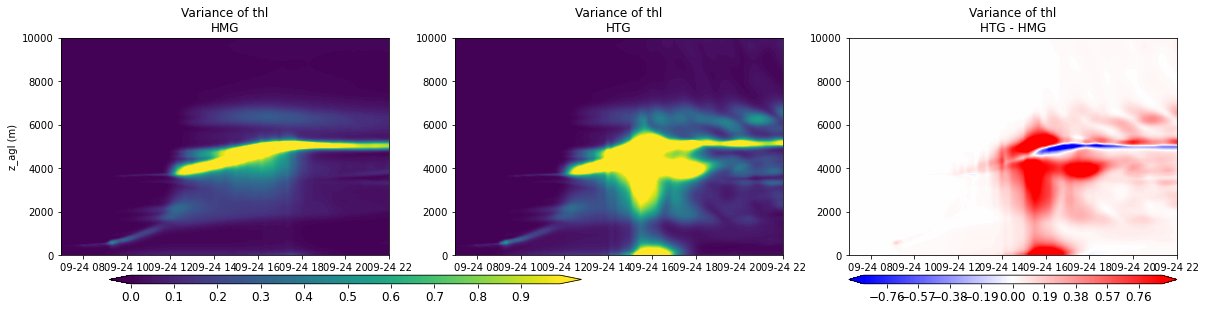

In [20]:
fig,axs=plt.subplots(1,3, figsize=(20,4))
axs = axs.ravel()

# levsc = np.arange(0.0,3.8,0.1)
levsc = np.arange(0.0,1.0,0.01)

axs[0].contourf(allTimesHMG, 
                meanZ_HMG, 
                HMGds.CSP_THL2.values.transpose(),
                levsc, extend='both' )

cplt = axs[1].contourf(allTimesHTG, 
                meanZ_HTG, 
                HTGds.CSP_THL2.values.transpose(),
                levsc, extend='both' )

axs[0].set_ylabel('z_agl (m)') 

axs[0].set_title(HMGds.CSP_THL2.description+'\nHMG')
axs[1].set_title(HMGds.CSP_THL2.description+'\nHTG')

# Add colorbar
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.24, ax_position.y0-0.1, ax_position.width+0.1, 0.03])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax)
cbar.ax.tick_params(labelsize=12)  

levsDiff = np.arange(-0.9, 0.91, 0.01)
cplt2 = axs[2].contourf(allTimesHTG, 
                meanZ_HTG, 
                HTGds.CSP_THL2.values.transpose() - HMGds.CSP_THL2.values.transpose(),
                levsDiff,cmap='bwr', extend='both' )
# Add colorbar
ax_position = axs[2].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(cplt2, orientation='horizontal',cax=cbar_ax)
cbar.ax.tick_params(labelsize=12)  
axs[2].set_title(HMGds.CSP_THL2.description+'\nHTG - HMG')

axs[0].set_ylim([0,10000])
axs[1].set_ylim([0,10000])
axs[2].set_ylim([0,10000])


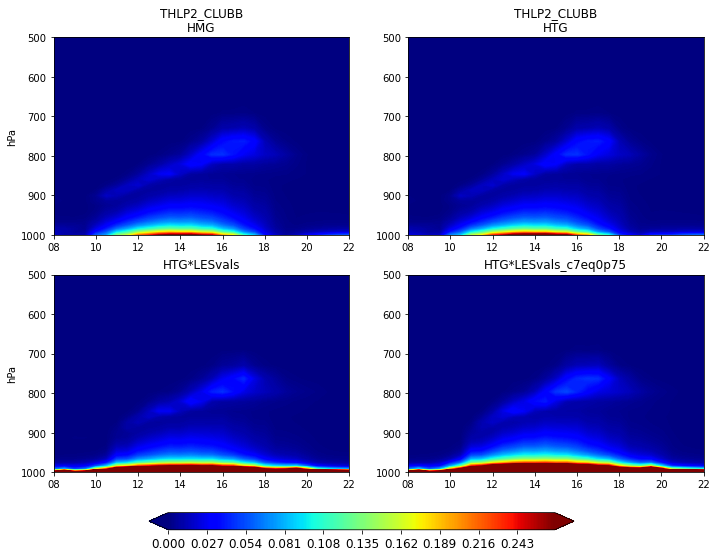

In [21]:
fig,axs = plt.subplots(2,3, figsize=(18,8))
axs     = axs.ravel()
fig.delaxes(axs[2])


## Plot HMG and the original HTG case 
levsc = np.arange(0.0,0.27,0.001)
cmapsel = 'jet'

axs[0].contourf(mult_all.sel(case='HMG').time.values, 
                mult_all.sel(case='HMG').ilev.values, 
                np.squeeze(mult_all.sel(case='HMG').THLP2_CLUBB.values).transpose(),
                levsc, cmap = cmapsel, extend='both' )

axs[1].contourf(mult_all.sel(case='HTG*01').time.values, 
                       mult_all.sel(case='HTG*01').ilev.values, 
                       np.squeeze(mult_all.sel(case='HTG*01').THLP2_CLUBB.values).transpose(),
                levsc, cmap =cmapsel, extend='both' )

axs[0].set_ylabel('hPa') 

axs[0].set_title('THLP2_CLUBB'+'\nHMG')
axs[1].set_title('THLP2_CLUBB'+'\nHTG')

axs[0].invert_yaxis()
axs[1].invert_yaxis()



## Plot the multiplier cases
axs[3].contourf(mult_all.sel(case='HTG*LESvals').time.values, 
                mult_all.sel(case='HTG*LESvals').ilev.values, 
                np.squeeze(mult_all.sel(case='HTG*LESvals').THLP2_CLUBB.values).transpose(),
                levsc, cmap=cmapsel, extend='both' )

cplt=axs[4].contourf(mult_all.sel(case='HTG*LESvals_c7eq0p75').time.values, 
                mult_all.sel(case='HTG*LESvals_c7eq0p75').ilev.values, 
                np.squeeze(mult_all.sel(case='HTG*LESvals_c7eq0p75').THLP2_CLUBB.values).transpose(),
                levsc, cmap = cmapsel, extend='both' )

axs[3].set_title('\nHTG*LESvals')
axs[4].set_title('\nHTG*LESvals_c7eq0p75')

# axs[3].contourf(mult_all.sel(case='HTG*05').time.values, 
#                 mult_all.sel(case='HTG*05').ilev.values, 
#                 np.squeeze(mult_all.sel(case='HTG*05').THLP2_CLUBB.values).transpose(),
#                 levsc, extend='both' )

# cplt = axs[4].contourf(mult_all.sel(case='HTG*10').time.values, 
#                        mult_all.sel(case='HTG*10').ilev.values, 
#                         np.squeeze(mult_all.sel(case='HTG*10').THLP2_CLUBB.values).transpose(),
#                 levsc, extend='both' )
# Add colorbar
ax_position = axs[4].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.2, ax_position.y0-0.1, ax_position.width+0.1, 0.03])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax)
cbar.ax.tick_params(labelsize=12)  

# axs[5].contourf(mult_all.sel(case='HTG*100').time.values, 
#                 mult_all.sel(case='HTG*100').ilev.values, 
#                 np.squeeze(mult_all.sel(case='HTG*100').THLP2_CLUBB.values).transpose(),
#                 levsc, extend='both' )

axs[3].set_ylabel('hPa') 

# axs[3].set_title('\nHTG*05')
# axs[4].set_title('\nHTG*10')
# axs[5].set_title('\nHTG*10')

axs[3].invert_yaxis()
axs[4].invert_yaxis()
# axs[5].invert_yaxis()

axs[0].set_ylim([1000,500])
axs[1].set_ylim([1000,500])
axs[3].set_ylim([1000,500])
axs[4].set_ylim([1000,500])
# axs[5].set_ylim([1000,500])


axs[0].set_xlim([mult_all.sel(case='HMG').time.values[16], mult_all.sel(case='HMG').time.values[-4]])
axs[1].set_xlim([mult_all.sel(case='HMG').time.values[16], mult_all.sel(case='HMG').time.values[-4]])
axs[3].set_xlim([mult_all.sel(case='HMG').time.values[16], mult_all.sel(case='HMG').time.values[-4]])
axs[4].set_xlim([mult_all.sel(case='HMG').time.values[16], mult_all.sel(case='HMG').time.values[-4]])
# axs[5].set_xlim([mult_all.sel(case='HMG').time.values[16], mult_all.sel(case='HMG').time.values[-4]])

axs[0].xaxis.set_major_formatter(DateFormatter("%H"))
axs[1].xaxis.set_major_formatter(DateFormatter("%H"))
axs[3].xaxis.set_major_formatter(DateFormatter("%H"))
axs[4].xaxis.set_major_formatter(DateFormatter("%H"))
# axs[5].xaxis.set_major_formatter(DateFormatter("%H"))

fig.delaxes(axs[5])


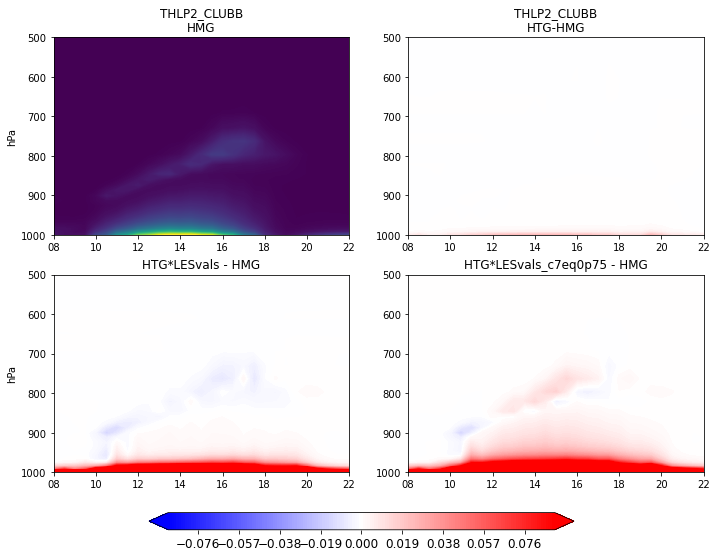

In [22]:
fig,axs = plt.subplots(2,3, figsize=(18,8))
axs     = axs.ravel()
fig.delaxes(axs[2])



## Plot HMG and the original HTG case 
levsc = np.arange(0.0,0.27,0.001)
levsDiff = np.arange(-0.09,0.091,0.001)

axs[0].contourf(mult_all.sel(case='HMG').time.values, 
                mult_all.sel(case='HMG').ilev.values, 
                np.squeeze(mult_all.sel(case='HMG').THLP2_CLUBB.values).transpose(),
                levsc, extend='both' )

axs[1].contourf(mult_all.sel(case='HTG*01').time.values, 
                       mult_all.sel(case='HTG*01').ilev.values, 
                       np.squeeze(mult_all.sel(case='HTG*01').THLP2_CLUBB.values - mult_all.sel(case='HMG').THLP2_CLUBB.values).transpose(),
                levsDiff, cmap ='bwr', extend='both' )

axs[0].set_ylabel('hPa') 

axs[0].set_title('THLP2_CLUBB'+'\nHMG')
axs[1].set_title('THLP2_CLUBB'+'\nHTG-HMG')

axs[0].invert_yaxis()
axs[1].invert_yaxis()



## Plot the multiplier cases
axs[3].contourf(mult_all.sel(case='HTG*LESvals').time.values, 
                mult_all.sel(case='HTG*LESvals').ilev.values, 
                np.squeeze(mult_all.sel(case='HTG*LESvals').THLP2_CLUBB.values - mult_all.sel(case='HMG').THLP2_CLUBB.values).transpose(),
                levsDiff, cmap='bwr', extend='both' )

cplt=axs[4].contourf(mult_all.sel(case='HTG*LESvals_c7eq0p75').time.values, 
                mult_all.sel(case='HTG*LESvals_c7eq0p75').ilev.values, 
                np.squeeze(mult_all.sel(case='HTG*LESvals_c7eq0p75').THLP2_CLUBB.values - mult_all.sel(case='HMG').THLP2_CLUBB.values).transpose(),
                levsDiff, cmap = 'bwr', extend='both' )

axs[3].set_title('\nHTG*LESvals - HMG')
axs[4].set_title('\nHTG*LESvals_c7eq0p75 - HMG')

# axs[3].contourf(mult_all.sel(case='HTG*05').time.values, 
#                 mult_all.sel(case='HTG*05').ilev.values, 
#                 np.squeeze(mult_all.sel(case='HTG*05').THLP2_CLUBB.values).transpose(),
#                 levsc, extend='both' )

# cplt = axs[4].contourf(mult_all.sel(case='HTG*10').time.values, 
#                        mult_all.sel(case='HTG*10').ilev.values, 
#                         np.squeeze(mult_all.sel(case='HTG*10').THLP2_CLUBB.values).transpose(),
#                 levsc, extend='both' )
# Add colorbar
ax_position = axs[4].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.2, ax_position.y0-0.1, ax_position.width+0.1, 0.03])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax)
cbar.ax.tick_params(labelsize=12)  

# axs[5].contourf(mult_all.sel(case='HTG*100').time.values, 
#                 mult_all.sel(case='HTG*100').ilev.values, 
#                 np.squeeze(mult_all.sel(case='HTG*100').THLP2_CLUBB.values).transpose(),
#                 levsc, extend='both' )

axs[3].set_ylabel('hPa') 

# axs[3].set_title('\nHTG*05')
# axs[4].set_title('\nHTG*10')
# axs[5].set_title('\nHTG*10')

axs[3].invert_yaxis()
axs[4].invert_yaxis()
# axs[5].invert_yaxis()

axs[0].set_ylim([1000,500])
axs[1].set_ylim([1000,500])
axs[3].set_ylim([1000,500])
axs[4].set_ylim([1000,500])
# axs[5].set_ylim([1000,500])


axs[0].set_xlim([mult_all.sel(case='HMG').time.values[16], mult_all.sel(case='HMG').time.values[-4]])
axs[1].set_xlim([mult_all.sel(case='HMG').time.values[16], mult_all.sel(case='HMG').time.values[-4]])
axs[3].set_xlim([mult_all.sel(case='HMG').time.values[16], mult_all.sel(case='HMG').time.values[-4]])
axs[4].set_xlim([mult_all.sel(case='HMG').time.values[16], mult_all.sel(case='HMG').time.values[-4]])
# axs[5].set_xlim([mult_all.sel(case='HMG').time.values[16], mult_all.sel(case='HMG').time.values[-4]])

axs[0].xaxis.set_major_formatter(DateFormatter("%H"))
axs[1].xaxis.set_major_formatter(DateFormatter("%H"))
axs[3].xaxis.set_major_formatter(DateFormatter("%H"))
axs[4].xaxis.set_major_formatter(DateFormatter("%H"))
# axs[5].xaxis.set_major_formatter(DateFormatter("%H"))

fig.delaxes(axs[5])


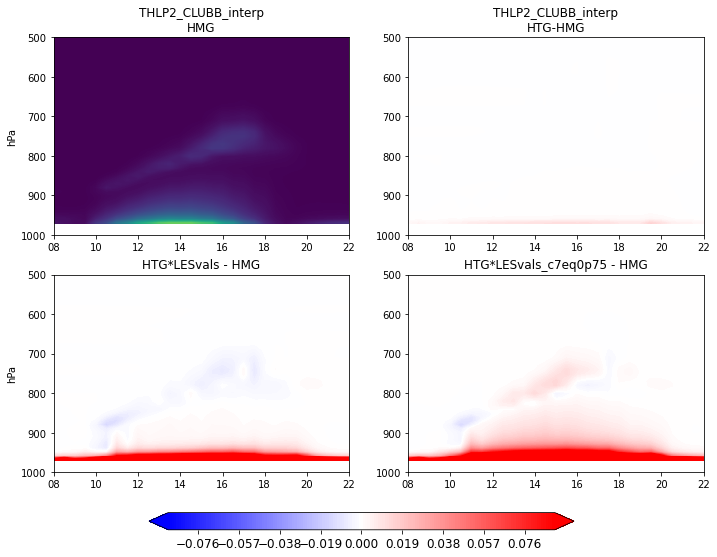

In [23]:
fig,axs = plt.subplots(2,3, figsize=(18,8))
axs     = axs.ravel()
fig.delaxes(axs[2])



## Plot HMG and the original HTG case 
levsc = np.arange(0.0,0.27,0.001)
levsDiff = np.arange(-0.09,0.091,0.001)

axs[0].contourf(mult_all.sel(case='HMG').time.values, 
                mult_all.sel(case='HMG').levInterp.values, 
                np.squeeze(mult_all.sel(case='HMG').THLP2_CLUBB_interp.values).transpose(),
                levsc, extend='both' )

axs[1].contourf(mult_all.sel(case='HTG*01').time.values, 
                       mult_all.sel(case='HTG*01').levInterp.values, 
                       np.squeeze(mult_all.sel(case='HTG*01').THLP2_CLUBB_interp.values - mult_all.sel(case='HMG').THLP2_CLUBB_interp.values).transpose(),
                levsDiff, cmap ='bwr', extend='both' )

axs[0].set_ylabel('hPa') 

axs[0].set_title('THLP2_CLUBB_interp'+'\nHMG')
axs[1].set_title('THLP2_CLUBB_interp'+'\nHTG-HMG')

axs[0].invert_yaxis()
axs[1].invert_yaxis()



## Plot the multiplier cases
axs[3].contourf(mult_all.sel(case='HTG*LESvals').time.values, 
                mult_all.sel(case='HTG*LESvals').levInterp.values, 
                np.squeeze(mult_all.sel(case='HTG*LESvals').THLP2_CLUBB_interp.values - mult_all.sel(case='HMG').THLP2_CLUBB_interp.values).transpose(),
                levsDiff, cmap='bwr', extend='both' )

cplt=axs[4].contourf(mult_all.sel(case='HTG*LESvals_c7eq0p75').time.values, 
                mult_all.sel(case='HTG*LESvals_c7eq0p75').levInterp.values, 
                np.squeeze(mult_all.sel(case='HTG*LESvals_c7eq0p75').THLP2_CLUBB_interp.values - mult_all.sel(case='HMG').THLP2_CLUBB_interp.values).transpose(),
                levsDiff, cmap = 'bwr', extend='both' )

axs[3].set_title('\nHTG*LESvals - HMG')
axs[4].set_title('\nHTG*LESvals_c7eq0p75 - HMG')

# Add colorbar
ax_position = axs[4].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.2, ax_position.y0-0.1, ax_position.width+0.1, 0.03])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax)
cbar.ax.tick_params(labelsize=12)  

axs[3].set_ylabel('hPa') 

axs[3].invert_yaxis()
axs[4].invert_yaxis()

axs[0].set_ylim([1000,500])
axs[1].set_ylim([1000,500])
axs[3].set_ylim([1000,500])
axs[4].set_ylim([1000,500])

axs[0].set_xlim([mult_all.sel(case='HMG').time.values[16], mult_all.sel(case='HMG').time.values[-4]])
axs[1].set_xlim([mult_all.sel(case='HMG').time.values[16], mult_all.sel(case='HMG').time.values[-4]])
axs[3].set_xlim([mult_all.sel(case='HMG').time.values[16], mult_all.sel(case='HMG').time.values[-4]])
axs[4].set_xlim([mult_all.sel(case='HMG').time.values[16], mult_all.sel(case='HMG').time.values[-4]])

axs[0].xaxis.set_major_formatter(DateFormatter("%H"))
axs[1].xaxis.set_major_formatter(DateFormatter("%H"))
axs[3].xaxis.set_major_formatter(DateFormatter("%H"))
axs[4].xaxis.set_major_formatter(DateFormatter("%H"))

fig.delaxes(axs[5])


KeyError: 'HTG*100'

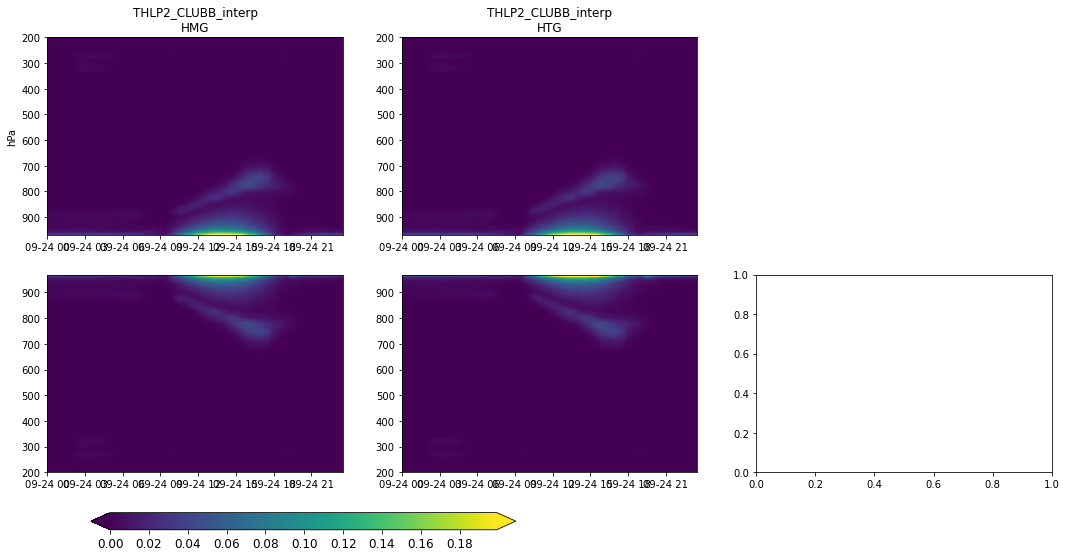

In [24]:
fig,axs = plt.subplots(2,3, figsize=(18,8))
axs     = axs.ravel()
fig.delaxes(axs[2])


## Plot HMG and the original HTG case 
levsc = np.arange(0.0,0.2,0.001)

axs[0].contourf(mult_all.sel(case='HMG').time.values, 
                mult_all.sel(case='HMG').levInterp.values, 
                np.squeeze(mult_all.sel(case='HMG').THLP2_CLUBB_interp.values).transpose(),
                levsc, extend='both' )

axs[1].contourf(mult_all.sel(case='HTG*01').time.values, 
                       mult_all.sel(case='HTG*01').levInterp.values, 
                       np.squeeze(mult_all.sel(case='HTG*01').THLP2_CLUBB_interp.values).transpose(),
                levsc, extend='both' )

axs[0].set_ylabel('hPa') 

axs[0].set_title('THLP2_CLUBB_interp'+'\nHMG')
axs[1].set_title('THLP2_CLUBB_interp'+'\nHTG')

axs[0].invert_yaxis()
axs[1].invert_yaxis()



## Plot the multiplier cases
axs[3].contourf(mult_all.sel(case='HTG*05').time.values, 
                mult_all.sel(case='HTG*05').levInterp.values, 
                np.squeeze(mult_all.sel(case='HTG*05').THLP2_CLUBB_interp.values).transpose(),
                levsc, extend='both' )

cplt = axs[4].contourf(mult_all.sel(case='HTG*10').time.values, 
                       mult_all.sel(case='HTG*10').levInterp.values, 
                        np.squeeze(mult_all.sel(case='HTG*10').THLP2_CLUBB_interp.values).transpose(),
                levsc, extend='both' )
# Add colorbar
ax_position = axs[4].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.24, ax_position.y0-0.1, ax_position.width+0.1, 0.03])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax)
cbar.ax.tick_params(labelsize=12)  

axs[5].contourf(mult_all.sel(case='HTG*100').time.values, 
                mult_all.sel(case='HTG*100').levInterp.values, 
                np.squeeze(mult_all.sel(case='HTG*100').THLP2_CLUBB_interp.values).transpose(),
                levsc, extend='both' )

axs[3].set_ylabel('hPa') 

axs[3].set_title('\nHTG*05')
axs[4].set_title('\nHTG*10')
axs[5].set_title('\nHTG*10')

axs[3].invert_yaxis()
axs[4].invert_yaxis()
axs[5].invert_yaxis()

axs[0].set_ylim([1000,500])
axs[1].set_ylim([1000,500])
axs[3].set_ylim([1000,500])
axs[4].set_ylim([1000,500])
axs[5].set_ylim([1000,500])


axs[0].set_xlim([mult_all.sel(case='HMG').time.values[16], mult_all.sel(case='HMG').time.values[-4]])
axs[1].set_xlim([mult_all.sel(case='HMG').time.values[16], mult_all.sel(case='HMG').time.values[-4]])
axs[3].set_xlim([mult_all.sel(case='HMG').time.values[16], mult_all.sel(case='HMG').time.values[-4]])
axs[4].set_xlim([mult_all.sel(case='HMG').time.values[16], mult_all.sel(case='HMG').time.values[-4]])
axs[5].set_xlim([mult_all.sel(case='HMG').time.values[16], mult_all.sel(case='HMG').time.values[-4]])

axs[0].xaxis.set_major_formatter(DateFormatter("%H"))
axs[1].xaxis.set_major_formatter(DateFormatter("%H"))
axs[3].xaxis.set_major_formatter(DateFormatter("%H"))
axs[4].xaxis.set_major_formatter(DateFormatter("%H"))
axs[5].xaxis.set_major_formatter(DateFormatter("%H"))


(0.0, 10000.0)

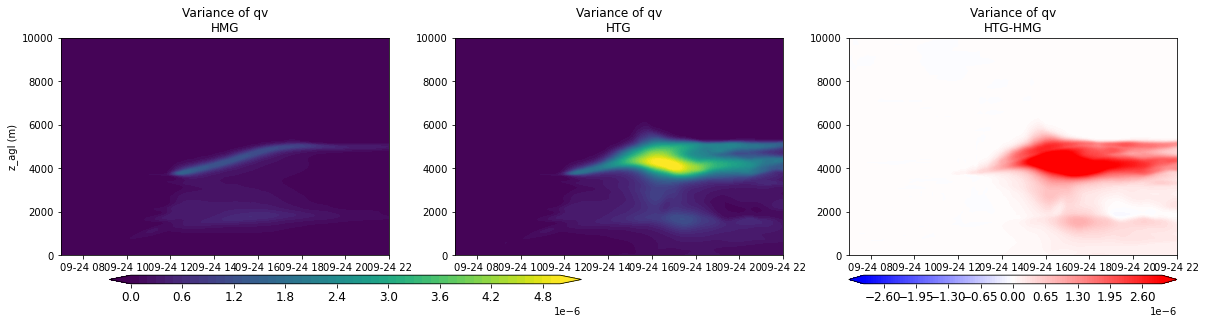

In [36]:
fig,axs=plt.subplots(1,3, figsize=(20,4))
axs = axs.ravel()

levsc = np.arange(0.0,5.0e-6,0.1e-6)

axs[0].contourf(allTimesHMG, 
                meanZ_HMG, 
                HMGds.CSP_QV2.values.transpose(),
                levsc, extend='both' )

cplt = axs[1].contourf(allTimesHTG, 
                meanZ_HTG, 
                HTGds.CSP_QV2.values.transpose(),
                levsc, extend='both' )

axs[0].set_ylabel('z_agl (m)') 

axs[0].set_title(HMGds.CSP_QV2.description+'\nHMG')
axs[1].set_title(HMGds.CSP_QV2.description+'\nHTG')

# Add colorbar
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.24, ax_position.y0-0.1, ax_position.width+0.1, 0.03])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax)
cbar.ax.tick_params(labelsize=12)  

levsDiff = np.arange(-3e-6, 3.05e-6, 0.05e-6)
cplt2 = axs[2].contourf(allTimesHTG, 
                meanZ_HTG, 
                HTGds.CSP_QV2.values.transpose() -  HMGds.CSP_QV2.values.transpose(),
                levsDiff, cmap='bwr', extend='both' )
# Add colorbar
ax_position = axs[2].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(cplt2, orientation='horizontal',cax=cbar_ax)
cbar.ax.tick_params(labelsize=12)  

axs[2].set_title(HMGds.CSP_QV2.description+'\nHTG-HMG')


axs[0].set_ylim([0,10000])
axs[1].set_ylim([0,10000])
axs[2].set_ylim([0,10000])



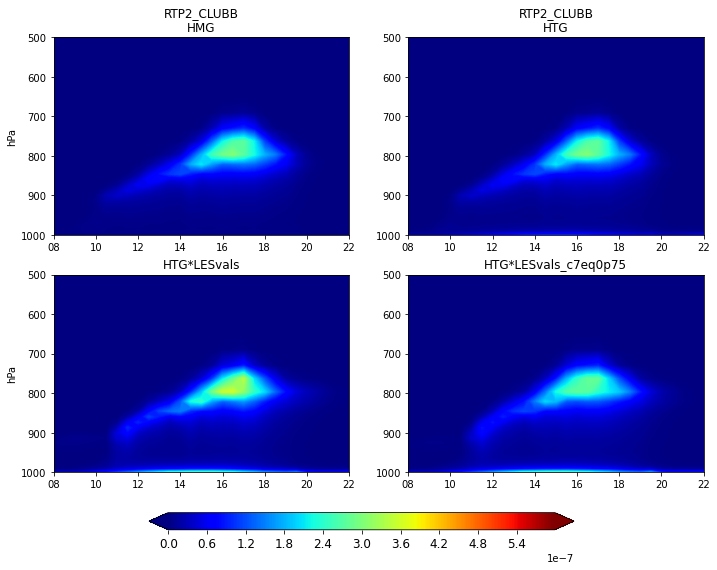

In [37]:
fig,axs = plt.subplots(2,3, figsize=(18,8))
axs     = axs.ravel()
fig.delaxes(axs[2])


## Plot HMG and the original HTG case 
levsc = np.arange(0.0,6e-7,0.01e-7)
cmapsel = 'jet'

axs[0].contourf(mult_all.sel(case='HMG').time.values, 
                mult_all.sel(case='HMG').ilev.values, 
                np.squeeze(mult_all.sel(case='HMG').RTP2_CLUBB.values*(10.0**-6)).transpose(),
                levsc, cmap = cmapsel, extend='both' )

axs[1].contourf(mult_all.sel(case='HTG*01').time.values, 
                       mult_all.sel(case='HTG*01').ilev.values, 
                       np.squeeze(mult_all.sel(case='HTG*01').RTP2_CLUBB.values*(10.0**-6)).transpose(),
                levsc, cmap =cmapsel, extend='both' )

axs[0].set_ylabel('hPa') 

axs[0].set_title('RTP2_CLUBB'+'\nHMG')
axs[1].set_title('RTP2_CLUBB'+'\nHTG')

axs[0].invert_yaxis()
axs[1].invert_yaxis()



## Plot the multiplier cases
axs[3].contourf(mult_all.sel(case='HTG*LESvals').time.values, 
                mult_all.sel(case='HTG*LESvals').ilev.values, 
                np.squeeze(mult_all.sel(case='HTG*LESvals').RTP2_CLUBB.values*(10.0**-6)).transpose(),
                levsc, cmap=cmapsel, extend='both' )

cplt=axs[4].contourf(mult_all.sel(case='HTG*LESvals_c7eq0p75').time.values, 
                mult_all.sel(case='HTG*LESvals_c7eq0p75').ilev.values, 
                np.squeeze(mult_all.sel(case='HTG*LESvals_c7eq0p75').RTP2_CLUBB.values*(10.0**-6)).transpose(),
                levsc, cmap = cmapsel, extend='both' )

axs[3].set_title('\nHTG*LESvals')
axs[4].set_title('\nHTG*LESvals_c7eq0p75')

# axs[3].contourf(mult_all.sel(case='HTG*05').time.values, 
#                 mult_all.sel(case='HTG*05').ilev.values, 
#                 np.squeeze(mult_all.sel(case='HTG*05').THLP2_CLUBB.values).transpose(),
#                 levsc, extend='both' )

# cplt = axs[4].contourf(mult_all.sel(case='HTG*10').time.values, 
#                        mult_all.sel(case='HTG*10').ilev.values, 
#                         np.squeeze(mult_all.sel(case='HTG*10').THLP2_CLUBB.values).transpose(),
#                 levsc, extend='both' )
# Add colorbar
ax_position = axs[4].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.2, ax_position.y0-0.1, ax_position.width+0.1, 0.03])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax)
cbar.ax.tick_params(labelsize=12)  

# axs[5].contourf(mult_all.sel(case='HTG*100').time.values, 
#                 mult_all.sel(case='HTG*100').ilev.values, 
#                 np.squeeze(mult_all.sel(case='HTG*100').THLP2_CLUBB.values).transpose(),
#                 levsc, extend='both' )

axs[3].set_ylabel('hPa') 

# axs[3].set_title('\nHTG*05')
# axs[4].set_title('\nHTG*10')
# axs[5].set_title('\nHTG*10')

axs[3].invert_yaxis()
axs[4].invert_yaxis()
# axs[5].invert_yaxis()

axs[0].set_ylim([1000,500])
axs[1].set_ylim([1000,500])
axs[3].set_ylim([1000,500])
axs[4].set_ylim([1000,500])
# axs[5].set_ylim([1000,500])


axs[0].set_xlim([mult_all.sel(case='HMG').time.values[16], mult_all.sel(case='HMG').time.values[-4]])
axs[1].set_xlim([mult_all.sel(case='HMG').time.values[16], mult_all.sel(case='HMG').time.values[-4]])
axs[3].set_xlim([mult_all.sel(case='HMG').time.values[16], mult_all.sel(case='HMG').time.values[-4]])
axs[4].set_xlim([mult_all.sel(case='HMG').time.values[16], mult_all.sel(case='HMG').time.values[-4]])
# axs[5].set_xlim([mult_all.sel(case='HMG').time.values[16], mult_all.sel(case='HMG').time.values[-4]])

axs[0].xaxis.set_major_formatter(DateFormatter("%H"))
axs[1].xaxis.set_major_formatter(DateFormatter("%H"))
axs[3].xaxis.set_major_formatter(DateFormatter("%H"))
axs[4].xaxis.set_major_formatter(DateFormatter("%H"))
# axs[5].xaxis.set_major_formatter(DateFormatter("%H"))

fig.delaxes(axs[5])


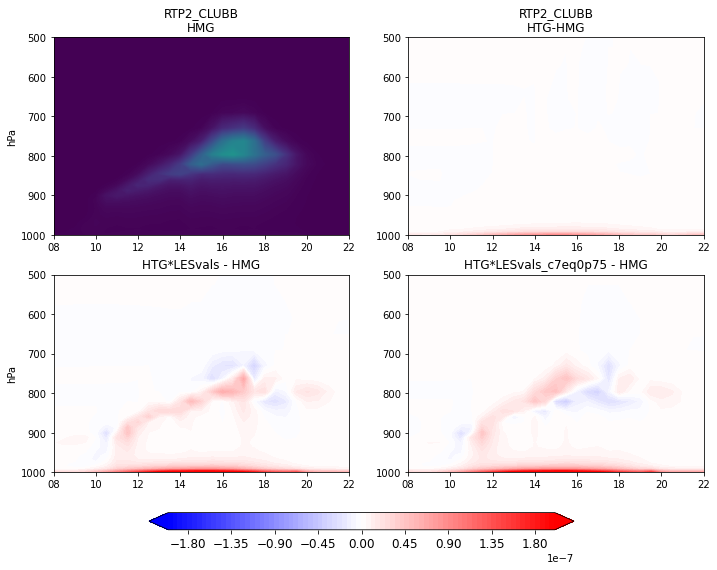

In [38]:
fig,axs = plt.subplots(2,3, figsize=(18,8))
axs     = axs.ravel()
fig.delaxes(axs[2])


## Plot HMG and the original HTG case 
levsc    = np.arange(0.0,6e-7,0.01e-7)
levsDiff = np.arange(-2e-7,2.05e-7,0.05e-7)

axs[0].contourf(mult_all.sel(case='HMG').time.values, 
                mult_all.sel(case='HMG').ilev.values, 
                np.squeeze(mult_all.sel(case='HMG').RTP2_CLUBB.values*(10.0**-6)).transpose(),
                levsc, extend='both' )

axs[1].contourf(mult_all.sel(case='HTG*01').time.values, 
                       mult_all.sel(case='HTG*01').ilev.values, 
                       np.squeeze(mult_all.sel(case='HTG*01').RTP2_CLUBB.values*(10.0**-6)- mult_all.sel(case='HMG').RTP2_CLUBB.values*(10.0**-6)).transpose(),
                levsDiff, cmap ='bwr', extend='both' )

axs[0].set_ylabel('hPa') 

axs[0].set_title('RTP2_CLUBB'+'\nHMG')
axs[1].set_title('RTP2_CLUBB'+'\nHTG-HMG')

axs[0].invert_yaxis()
axs[1].invert_yaxis()



## Plot the multiplier cases
axs[3].contourf(mult_all.sel(case='HTG*LESvals').time.values, 
                mult_all.sel(case='HTG*LESvals').ilev.values, 
                np.squeeze(mult_all.sel(case='HTG*LESvals').RTP2_CLUBB.values*(10.0**-6) - mult_all.sel(case='HMG').RTP2_CLUBB.values*(10.0**-6)).transpose(),
                levsDiff, cmap='bwr', extend='both' )

cplt=axs[4].contourf(mult_all.sel(case='HTG*LESvals_c7eq0p75').time.values, 
                mult_all.sel(case='HTG*LESvals_c7eq0p75').ilev.values, 
                np.squeeze(mult_all.sel(case='HTG*LESvals_c7eq0p75').RTP2_CLUBB.values*(10.0**-6) - mult_all.sel(case='HMG').RTP2_CLUBB.values*(10.0**-6)).transpose(),
                levsDiff, cmap = 'bwr', extend='both' )

axs[3].set_title('\nHTG*LESvals - HMG')
axs[4].set_title('\nHTG*LESvals_c7eq0p75 - HMG')

# axs[3].contourf(mult_all.sel(case='HTG*05').time.values, 
#                 mult_all.sel(case='HTG*05').ilev.values, 
#                 np.squeeze(mult_all.sel(case='HTG*05').THLP2_CLUBB.values).transpose(),
#                 levsc, extend='both' )

# cplt = axs[4].contourf(mult_all.sel(case='HTG*10').time.values, 
#                        mult_all.sel(case='HTG*10').ilev.values, 
#                         np.squeeze(mult_all.sel(case='HTG*10').THLP2_CLUBB.values).transpose(),
#                 levsc, extend='both' )
# Add colorbar
ax_position = axs[4].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.2, ax_position.y0-0.1, ax_position.width+0.1, 0.03])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax)
cbar.ax.tick_params(labelsize=12)  

# axs[5].contourf(mult_all.sel(case='HTG*100').time.values, 
#                 mult_all.sel(case='HTG*100').ilev.values, 
#                 np.squeeze(mult_all.sel(case='HTG*100').THLP2_CLUBB.values).transpose(),
#                 levsc, extend='both' )

axs[3].set_ylabel('hPa') 

# axs[3].set_title('\nHTG*05')
# axs[4].set_title('\nHTG*10')
# axs[5].set_title('\nHTG*10')

axs[3].invert_yaxis()
axs[4].invert_yaxis()
# axs[5].invert_yaxis()

axs[0].set_ylim([1000,500])
axs[1].set_ylim([1000,500])
axs[3].set_ylim([1000,500])
axs[4].set_ylim([1000,500])
# axs[5].set_ylim([1000,500])


axs[0].set_xlim([mult_all.sel(case='HMG').time.values[16], mult_all.sel(case='HMG').time.values[-4]])
axs[1].set_xlim([mult_all.sel(case='HMG').time.values[16], mult_all.sel(case='HMG').time.values[-4]])
axs[3].set_xlim([mult_all.sel(case='HMG').time.values[16], mult_all.sel(case='HMG').time.values[-4]])
axs[4].set_xlim([mult_all.sel(case='HMG').time.values[16], mult_all.sel(case='HMG').time.values[-4]])
# axs[5].set_xlim([mult_all.sel(case='HMG').time.values[16], mult_all.sel(case='HMG').time.values[-4]])

axs[0].xaxis.set_major_formatter(DateFormatter("%H"))
axs[1].xaxis.set_major_formatter(DateFormatter("%H"))
axs[3].xaxis.set_major_formatter(DateFormatter("%H"))
axs[4].xaxis.set_major_formatter(DateFormatter("%H"))
# axs[5].xaxis.set_major_formatter(DateFormatter("%H"))

fig.delaxes(axs[5])


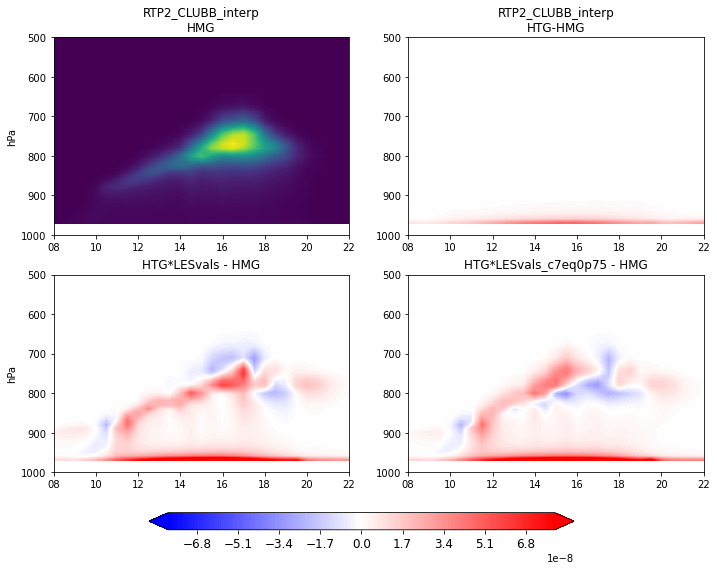

In [40]:
fig,axs = plt.subplots(2,3, figsize=(18,8))
axs     = axs.ravel()
fig.delaxes(axs[2])


## Plot HMG and the original HTG case 
levsc    = np.arange(0.0,3e-7,0.01e-7)
levsDiff = np.arange(-0.8e-7,0.81e-7,0.01e-7)

axs[0].contourf(mult_all.sel(case='HMG').time.values, 
                mult_all.sel(case='HMG').levInterp.values, 
                np.squeeze(mult_all.sel(case='HMG').RTP2_CLUBB_interp.values*(10.0**-6)).transpose(),
                levsc, extend='both' )

axs[1].contourf(mult_all.sel(case='HTG*01').time.values, 
                       mult_all.sel(case='HTG*01').levInterp.values, 
                       np.squeeze(mult_all.sel(case='HTG*01').RTP2_CLUBB_interp.values*(10.0**-6)- mult_all.sel(case='HMG').RTP2_CLUBB_interp.values*(10.0**-6)).transpose(),
                levsDiff, cmap ='bwr', extend='both' )

axs[0].set_ylabel('hPa') 

axs[0].set_title('RTP2_CLUBB_interp'+'\nHMG')
axs[1].set_title('RTP2_CLUBB_interp'+'\nHTG-HMG')

axs[0].invert_yaxis()
axs[1].invert_yaxis()


## Plot the multiplier cases
axs[3].contourf(mult_all.sel(case='HTG*LESvals').time.values, 
                mult_all.sel(case='HTG*LESvals').levInterp.values, 
                np.squeeze(mult_all.sel(case='HTG*LESvals').RTP2_CLUBB_interp.values*(10.0**-6) - mult_all.sel(case='HMG').RTP2_CLUBB_interp.values*(10.0**-6)).transpose(),
                levsDiff, cmap='bwr', extend='both' )

cplt=axs[4].contourf(mult_all.sel(case='HTG*LESvals_c7eq0p75').time.values, 
                mult_all.sel(case='HTG*LESvals_c7eq0p75').levInterp.values, 
                np.squeeze(mult_all.sel(case='HTG*LESvals_c7eq0p75').RTP2_CLUBB_interp.values*(10.0**-6) - mult_all.sel(case='HMG').RTP2_CLUBB_interp.values*(10.0**-6)).transpose(),
                levsDiff, cmap = 'bwr', extend='both' )

axs[3].set_title('\nHTG*LESvals - HMG')
axs[4].set_title('\nHTG*LESvals_c7eq0p75 - HMG')

# Add colorbar
ax_position = axs[4].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.2, ax_position.y0-0.1, ax_position.width+0.1, 0.03])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax)
cbar.ax.tick_params(labelsize=12)  


axs[3].set_ylabel('hPa') 


axs[3].invert_yaxis()
axs[4].invert_yaxis()

axs[0].set_ylim([1000,500])
axs[1].set_ylim([1000,500])
axs[3].set_ylim([1000,500])
axs[4].set_ylim([1000,500])

axs[0].set_xlim([mult_all.sel(case='HMG').time.values[16], mult_all.sel(case='HMG').time.values[-4]])
axs[1].set_xlim([mult_all.sel(case='HMG').time.values[16], mult_all.sel(case='HMG').time.values[-4]])
axs[3].set_xlim([mult_all.sel(case='HMG').time.values[16], mult_all.sel(case='HMG').time.values[-4]])
axs[4].set_xlim([mult_all.sel(case='HMG').time.values[16], mult_all.sel(case='HMG').time.values[-4]])

axs[0].xaxis.set_major_formatter(DateFormatter("%H"))
axs[1].xaxis.set_major_formatter(DateFormatter("%H"))
axs[3].xaxis.set_major_formatter(DateFormatter("%H"))
axs[4].xaxis.set_major_formatter(DateFormatter("%H"))

fig.delaxes(axs[5])


In [ ]:
fig,axs = plt.subplots(2,3, figsize=(18,8))
axs     = axs.ravel()
fig.delaxes(axs[2])


## Plot HMG and the original HTG case 
levsc = np.arange(0.0,7e-7,0.01e-7)

axs[0].contourf(mult_all.sel(case='HMG').time.values, 
                mult_all.sel(case='HMG').levInterp.values, 
                np.squeeze(mult_all.sel(case='HMG').RTP2_CLUBB_interp.values*(10.0**-6)).transpose(),
                levsc, extend='both' )

axs[1].contourf(mult_all.sel(case='HTG*01').time.values, 
                       mult_all.sel(case='HTG*01').levInterp.values, 
                       np.squeeze(mult_all.sel(case='HTG*01').RTP2_CLUBB_interp.values*(10.0**-6)).transpose(),
                levsc, extend='both' )

axs[0].set_ylabel('hPa') 

axs[0].set_title('RTP2_CLUBB_interp'+'\nHMG')
axs[1].set_title('RTP2_CLUBB_interp'+'\nHTG')

axs[0].invert_yaxis()
axs[1].invert_yaxis()


## Plot the multiplier cases
axs[3].contourf(mult_all.sel(case='HTG*05').time.values, 
                mult_all.sel(case='HTG*05').levInterp.values, 
                np.squeeze(mult_all.sel(case='HTG*05').RTP2_CLUBB_interp.values*(10.0**-6)).transpose(),
                levsc, extend='both' )

cplt = axs[4].contourf(mult_all.sel(case='HTG*10').time.values, 
                       mult_all.sel(case='HTG*10').levInterp.values, 
                        np.squeeze(mult_all.sel(case='HTG*10').RTP2_CLUBB_interp.values*(10.0**-6)).transpose(),
                levsc, extend='both' )
# Add colorbar
ax_position = axs[4].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.24, ax_position.y0-0.1, ax_position.width+0.1, 0.03])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax)
cbar.ax.tick_params(labelsize=12)  

axs[5].contourf(mult_all.sel(case='HTG*100').time.values, 
                mult_all.sel(case='HTG*100').levInterp.values, 
                np.squeeze(mult_all.sel(case='HTG*100').RTP2_CLUBB_interp.values*(10.0**-6)).transpose(),
                levsc, extend='both' )

axs[3].set_ylabel('hPa') 

axs[3].set_title('\nHTG*05')
axs[4].set_title('\nHTG*10')
axs[5].set_title('\nHTG*10')

axs[3].invert_yaxis()
axs[4].invert_yaxis()
axs[5].invert_yaxis()

axs[0].set_ylim([1000,500])
axs[1].set_ylim([1000,500])
axs[3].set_ylim([1000,500])
axs[4].set_ylim([1000,500])
axs[5].set_ylim([1000,500])

axs[0].set_xlim([mult_all.sel(case='HMG').time.values[16], mult_all.sel(case='HMG').time.values[-4]])
axs[1].set_xlim([mult_all.sel(case='HMG').time.values[16], mult_all.sel(case='HMG').time.values[-4]])
axs[3].set_xlim([mult_all.sel(case='HMG').time.values[16], mult_all.sel(case='HMG').time.values[-4]])
axs[4].set_xlim([mult_all.sel(case='HMG').time.values[16], mult_all.sel(case='HMG').time.values[-4]])
axs[5].set_xlim([mult_all.sel(case='HMG').time.values[16], mult_all.sel(case='HMG').time.values[-4]])

axs[0].xaxis.set_major_formatter(DateFormatter("%H"))
axs[1].xaxis.set_major_formatter(DateFormatter("%H"))
axs[3].xaxis.set_major_formatter(DateFormatter("%H"))
axs[4].xaxis.set_major_formatter(DateFormatter("%H"))
axs[5].xaxis.set_major_formatter(DateFormatter("%H"))


(0.0, 10000.0)

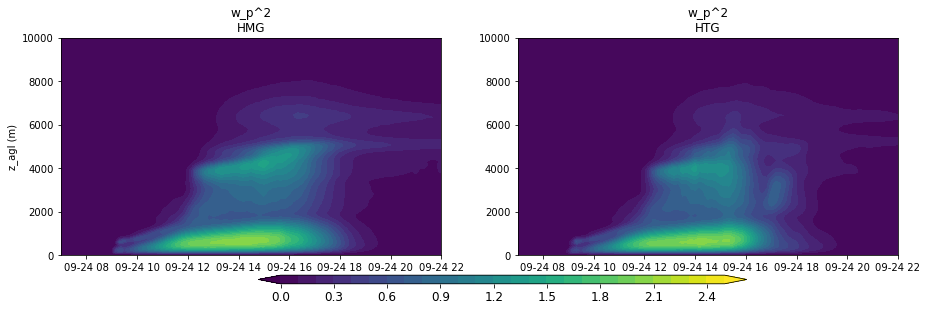

In [41]:
fig,axs=plt.subplots(1,2, figsize=(15,4))
axs = axs.ravel()

levsc = np.arange(0.0,2.6,0.1)

axs[0].contourf(allTimesHMG, 
                meanZstag_HMG, 
                HMGds.CSP_W2.values.transpose(),
                levsc, extend='both' )

cplt = axs[1].contourf(allTimesHTG, 
                meanZstag_HTG, 
                HTGds.CSP_W2.values.transpose(),
                levsc, extend='both' )

axs[0].set_ylabel('z_agl (m)') 

axs[0].set_title(HMGds.CSP_W2.description+'\nHMG')
axs[1].set_title(HMGds.CSP_W2.description+'\nHTG')

# Add colorbar
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.24, ax_position.y0-0.1, ax_position.width+0.1, 0.03])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax)
cbar.ax.tick_params(labelsize=12)  

axs[0].set_ylim([0,10000])
axs[1].set_ylim([0,10000])

(0.0, 10000.0)

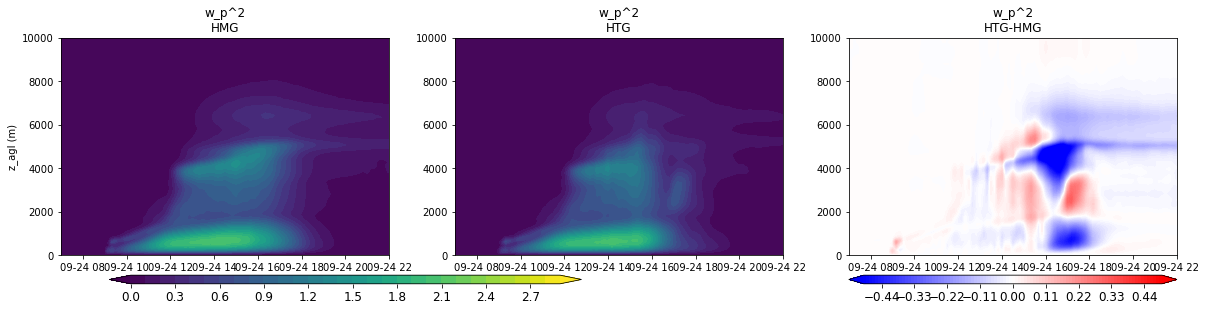

In [42]:
fig,axs=plt.subplots(1,3, figsize=(20,4))
axs = axs.ravel()

levsc    = np.arange(0,3,0.1)

axs[0].contourf(allTimesHMG, 
                meanZstag_HMG, 
                HMGds.CSP_W2.values.transpose(),
                levsc, extend='both' )

cplt = axs[1].contourf(allTimesHTG, 
                meanZstag_HTG, 
                HTGds.CSP_W2.values.transpose(),
                levsc, extend='both' )

axs[0].set_ylabel('z_agl (m)') 

axs[0].set_title(HMGds.CSP_W2.description+'\nHMG')
axs[1].set_title(HMGds.CSP_W2.description+'\nHTG')

# Add colorbar
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.24, ax_position.y0-0.1, ax_position.width+0.1, 0.03])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax)
cbar.ax.tick_params(labelsize=12)  

levsDiff = np.arange(-0.5, 0.51, 0.01)
cplt2 = axs[2].contourf(allTimesHTG, 
                meanZstag_HTG, 
                HTGds.CSP_W2.values.transpose() -  HMGds.CSP_W2.values.transpose(),
                levsDiff, cmap='bwr', extend='both' )
# Add colorbar
ax_position = axs[2].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(cplt2, orientation='horizontal',cax=cbar_ax)
cbar.ax.tick_params(labelsize=12)  

axs[2].set_title(HMGds.CSP_W2.description+'\nHTG-HMG')


axs[0].set_ylim([0,10000])
axs[1].set_ylim([0,10000])
axs[2].set_ylim([0,10000])



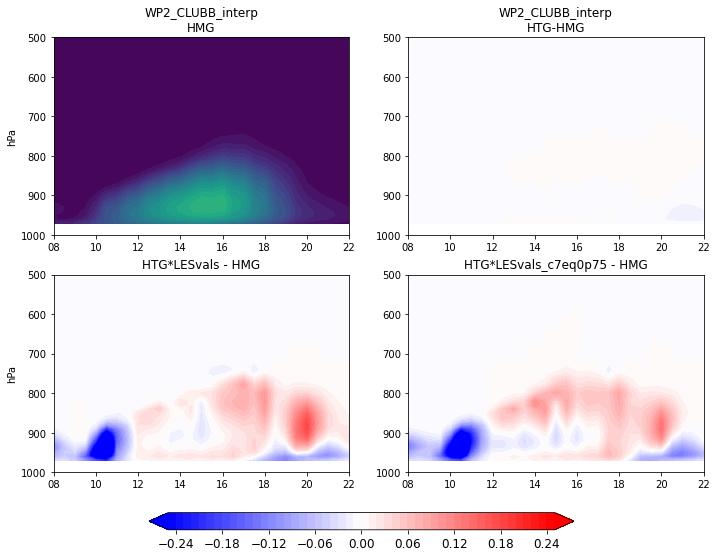

In [44]:
fig,axs = plt.subplots(2,3, figsize=(18,8))
axs     = axs.ravel()
fig.delaxes(axs[2])


## Plot HMG and the original HTG case 
levsc    = np.arange(0,3,0.1)
levsDiff = np.arange(-0.25,0.26,0.01)

axs[0].contourf(mult_all.sel(case='HMG').time.values, 
                mult_all.sel(case='HMG').levInterp.values, 
                np.squeeze(mult_all.sel(case='HMG').WP2_CLUBB_interp.values).transpose(),
                levsc, extend='both' )

axs[1].contourf(mult_all.sel(case='HTG*01').time.values, 
                       mult_all.sel(case='HTG*01').levInterp.values, 
                       np.squeeze(mult_all.sel(case='HTG*01').WP2_CLUBB_interp.values- mult_all.sel(case='HMG').WP2_CLUBB_interp.values).transpose(),
                levsDiff, cmap ='bwr', extend='both' )

axs[0].set_ylabel('hPa') 

axs[0].set_title('WP2_CLUBB_interp'+'\nHMG')
axs[1].set_title('WP2_CLUBB_interp'+'\nHTG-HMG')

axs[0].invert_yaxis()
axs[1].invert_yaxis()



## Plot the multiplier cases
axs[3].contourf(mult_all.sel(case='HTG*LESvals').time.values, 
                mult_all.sel(case='HTG*LESvals').levInterp.values, 
                np.squeeze(mult_all.sel(case='HTG*LESvals').WP2_CLUBB_interp.values - mult_all.sel(case='HMG').WP2_CLUBB_interp.values).transpose(),
                levsDiff, cmap='bwr', extend='both' )

cplt=axs[4].contourf(mult_all.sel(case='HTG*LESvals_c7eq0p75').time.values, 
                mult_all.sel(case='HTG*LESvals_c7eq0p75').levInterp.values, 
                np.squeeze(mult_all.sel(case='HTG*LESvals_c7eq0p75').WP2_CLUBB_interp.values - mult_all.sel(case='HMG').WP2_CLUBB_interp.values).transpose(),
                levsDiff, cmap = 'bwr', extend='both' )

axs[3].set_title('\nHTG*LESvals - HMG')
axs[4].set_title('\nHTG*LESvals_c7eq0p75 - HMG')

# axs[3].contourf(mult_all.sel(case='HTG*05').time.values, 
#                 mult_all.sel(case='HTG*05').ilev.values, 
#                 np.squeeze(mult_all.sel(case='HTG*05').THLP2_CLUBB.values).transpose(),
#                 levsc, extend='both' )

# cplt = axs[4].contourf(mult_all.sel(case='HTG*10').time.values, 
#                        mult_all.sel(case='HTG*10').ilev.values, 
#                         np.squeeze(mult_all.sel(case='HTG*10').THLP2_CLUBB.values).transpose(),
#                 levsc, extend='both' )
# Add colorbar
ax_position = axs[4].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.2, ax_position.y0-0.1, ax_position.width+0.1, 0.03])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax)
cbar.ax.tick_params(labelsize=12)  

# axs[5].contourf(mult_all.sel(case='HTG*100').time.values, 
#                 mult_all.sel(case='HTG*100').ilev.values, 
#                 np.squeeze(mult_all.sel(case='HTG*100').THLP2_CLUBB.values).transpose(),
#                 levsc, extend='both' )

axs[3].set_ylabel('hPa') 

# axs[3].set_title('\nHTG*05')
# axs[4].set_title('\nHTG*10')
# axs[5].set_title('\nHTG*10')

axs[3].invert_yaxis()
axs[4].invert_yaxis()
# axs[5].invert_yaxis()

axs[0].set_ylim([1000,500])
axs[1].set_ylim([1000,500])
axs[3].set_ylim([1000,500])
axs[4].set_ylim([1000,500])
# axs[5].set_ylim([1000,500])


axs[0].set_xlim([mult_all.sel(case='HMG').time.values[16], mult_all.sel(case='HMG').time.values[-4]])
axs[1].set_xlim([mult_all.sel(case='HMG').time.values[16], mult_all.sel(case='HMG').time.values[-4]])
axs[3].set_xlim([mult_all.sel(case='HMG').time.values[16], mult_all.sel(case='HMG').time.values[-4]])
axs[4].set_xlim([mult_all.sel(case='HMG').time.values[16], mult_all.sel(case='HMG').time.values[-4]])
# axs[5].set_xlim([mult_all.sel(case='HMG').time.values[16], mult_all.sel(case='HMG').time.values[-4]])

axs[0].xaxis.set_major_formatter(DateFormatter("%H"))
axs[1].xaxis.set_major_formatter(DateFormatter("%H"))
axs[3].xaxis.set_major_formatter(DateFormatter("%H"))
axs[4].xaxis.set_major_formatter(DateFormatter("%H"))
# axs[5].xaxis.set_major_formatter(DateFormatter("%H"))

fig.delaxes(axs[5])


KeyError: 'HTG*100'

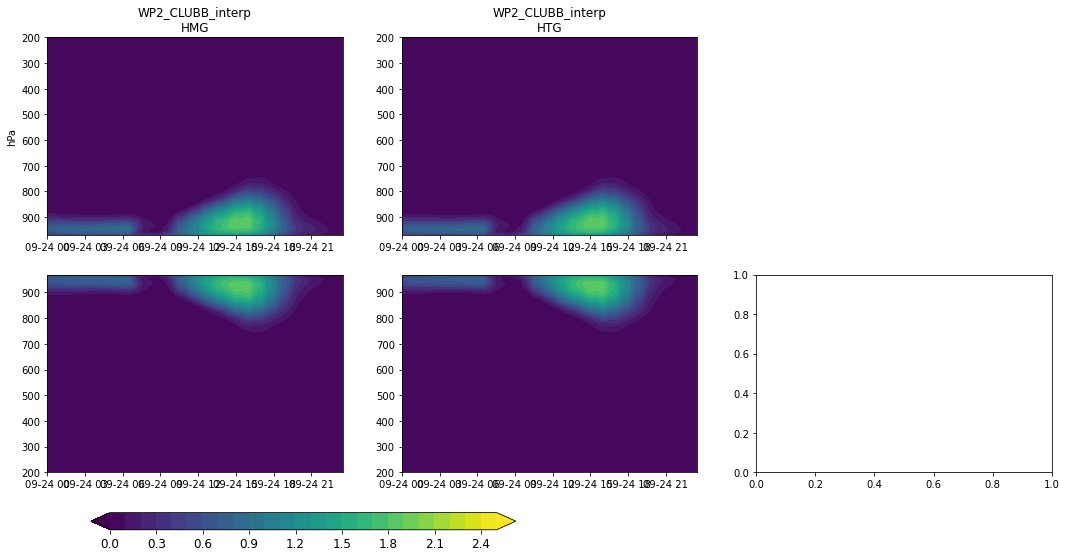

In [45]:
fig,axs = plt.subplots(2,3, figsize=(18,8))
axs     = axs.ravel()
fig.delaxes(axs[2])


## Plot HMG and the original HTG case 
levsc = np.arange(0.0,2.6,0.1)

axs[0].contourf(mult_all.sel(case='HMG').time.values, 
                mult_all.sel(case='HMG').levInterp.values, 
                np.squeeze(mult_all.sel(case='HMG').WP2_CLUBB_interp.values).transpose(),
                levsc, extend='both' )

axs[1].contourf(mult_all.sel(case='HTG*01').time.values, 
                       mult_all.sel(case='HTG*01').levInterp.values, 
                       np.squeeze(mult_all.sel(case='HTG*01').WP2_CLUBB_interp.values).transpose(),
                levsc, extend='both' )

axs[0].set_ylabel('hPa') 

axs[0].set_title('WP2_CLUBB_interp'+'\nHMG')
axs[1].set_title('WP2_CLUBB_interp'+'\nHTG')

axs[0].invert_yaxis()
axs[1].invert_yaxis()

## Plot the multiplier cases
axs[3].contourf(mult_all.sel(case='HTG*05').time.values, 
                mult_all.sel(case='HTG*05').levInterp.values, 
                np.squeeze(mult_all.sel(case='HTG*05').WP2_CLUBB_interp.values).transpose(),
                levsc, extend='both' )

cplt = axs[4].contourf(mult_all.sel(case='HTG*10').time.values, 
                       mult_all.sel(case='HTG*10').levInterp.values, 
                        np.squeeze(mult_all.sel(case='HTG*10').WP2_CLUBB_interp.values).transpose(),
                levsc, extend='both' )
# Add colorbar
ax_position = axs[4].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.24, ax_position.y0-0.1, ax_position.width+0.1, 0.03])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax)
cbar.ax.tick_params(labelsize=12)  

axs[5].contourf(mult_all.sel(case='HTG*100').time.values, 
                mult_all.sel(case='HTG*100').levInterp.values, 
                np.squeeze(mult_all.sel(case='HTG*100').WP2_CLUBB_interp.values).transpose(),
                levsc, extend='both' )

axs[3].set_ylabel('hPa') 

axs[3].set_title('\nHTG*05')
axs[4].set_title('\nHTG*10')
axs[5].set_title('\nHTG*10')

axs[3].invert_yaxis()
axs[4].invert_yaxis()
axs[5].invert_yaxis()

axs[0].set_ylim([1000,500])
axs[1].set_ylim([1000,500])
axs[3].set_ylim([1000,500])
axs[4].set_ylim([1000,500])
axs[5].set_ylim([1000,500])

axs[0].set_xlim([mult_all.sel(case='HMG').time.values[16], mult_all.sel(case='HMG').time.values[-4]])
axs[1].set_xlim([mult_all.sel(case='HMG').time.values[16], mult_all.sel(case='HMG').time.values[-4]])
axs[3].set_xlim([mult_all.sel(case='HMG').time.values[16], mult_all.sel(case='HMG').time.values[-4]])
axs[4].set_xlim([mult_all.sel(case='HMG').time.values[16], mult_all.sel(case='HMG').time.values[-4]])
axs[5].set_xlim([mult_all.sel(case='HMG').time.values[16], mult_all.sel(case='HMG').time.values[-4]])

axs[0].xaxis.set_major_formatter(DateFormatter("%H"))
axs[1].xaxis.set_major_formatter(DateFormatter("%H"))
axs[3].xaxis.set_major_formatter(DateFormatter("%H"))
axs[4].xaxis.set_major_formatter(DateFormatter("%H"))
axs[5].xaxis.set_major_formatter(DateFormatter("%H"))


(0.0, 10000.0)

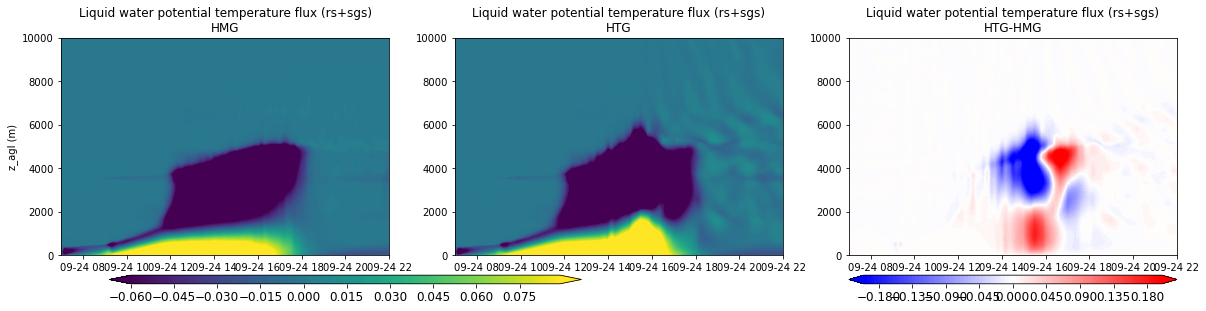

In [46]:
fig,axs=plt.subplots(1,3, figsize=(20,4))
axs = axs.ravel()

levsc = np.arange(-6e-2,9e-2,1e-3)

axs[0].contourf(allTimesHMG, 
                meanZ_HMG, 
                HMGds.CSP_WTHL.values.transpose(),
                levsc, extend='both' )

cplt = axs[1].contourf(allTimesHTG, 
                meanZ_HTG, 
                HTGds.CSP_WTHL.values.transpose(),
                levsc, extend='both' )

axs[0].set_ylabel('z_agl (m)') 

axs[0].set_title(HMGds.CSP_WTHL.description+'\nHMG')
axs[1].set_title(HMGds.CSP_WTHL.description+'\nHTG')

# Add colorbar
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.24, ax_position.y0-0.1, ax_position.width+0.1, 0.03])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax)
cbar.ax.tick_params(labelsize=12)  

levsDiff = np.arange(-0.2, 0.205, 0.005)
cplt2 = axs[2].contourf(allTimesHTG, 
                meanZ_HTG, 
                HTGds.CSP_WTHL.values.transpose() -  HMGds.CSP_WTHL.values.transpose(),
                levsDiff, cmap='bwr', extend='both' )
# Add colorbar
ax_position = axs[2].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.1, ax_position.width, 0.03])
cbar = plt.colorbar(cplt2, orientation='horizontal',cax=cbar_ax)
cbar.ax.tick_params(labelsize=12)  

axs[2].set_title(HMGds.CSP_WTHL.description+'\nHTG-HMG')


axs[0].set_ylim([0,10000])
axs[1].set_ylim([0,10000])
axs[2].set_ylim([0,10000])



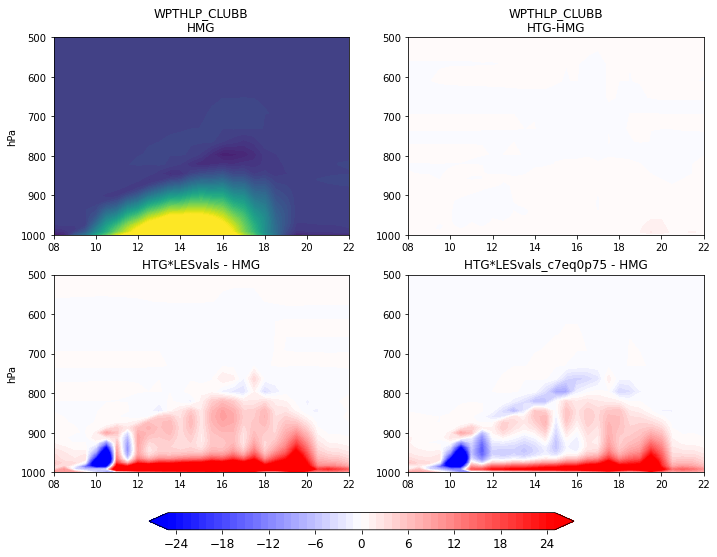

In [47]:
fig,axs = plt.subplots(2,3, figsize=(18,8))
axs     = axs.ravel()
fig.delaxes(axs[2])


## Plot HMG and the original HTG case 
levsc    = np.arange(-50,200,5)
levsDiff = np.arange(-25,26,1)

axs[0].contourf(mult_all.sel(case='HMG').time.values, 
                mult_all.sel(case='HMG').ilev.values, 
                np.squeeze(mult_all.sel(case='HMG').WPTHLP_CLUBB.values).transpose(),
                levsc, extend='both' )

axs[1].contourf(mult_all.sel(case='HTG*01').time.values, 
                       mult_all.sel(case='HTG*01').ilev.values, 
                       np.squeeze(mult_all.sel(case='HTG*01').WPTHLP_CLUBB.values- mult_all.sel(case='HMG').WPTHLP_CLUBB.values).transpose(),
                levsDiff, cmap ='bwr', extend='both' )

axs[0].set_ylabel('hPa') 

axs[0].set_title('WPTHLP_CLUBB'+'\nHMG')
axs[1].set_title('WPTHLP_CLUBB'+'\nHTG-HMG')

axs[0].invert_yaxis()
axs[1].invert_yaxis()



## Plot the multiplier cases
axs[3].contourf(mult_all.sel(case='HTG*LESvals').time.values, 
                mult_all.sel(case='HTG*LESvals').ilev.values, 
                np.squeeze(mult_all.sel(case='HTG*LESvals').WPTHLP_CLUBB.values - mult_all.sel(case='HMG').WPTHLP_CLUBB.values).transpose(),
                levsDiff, cmap='bwr', extend='both' )

cplt=axs[4].contourf(mult_all.sel(case='HTG*LESvals_c7eq0p75').time.values, 
                mult_all.sel(case='HTG*LESvals_c7eq0p75').ilev.values, 
                np.squeeze(mult_all.sel(case='HTG*LESvals_c7eq0p75').WPTHLP_CLUBB.values - mult_all.sel(case='HMG').WPTHLP_CLUBB.values).transpose(),
                levsDiff, cmap = 'bwr', extend='both' )

axs[3].set_title('\nHTG*LESvals - HMG')
axs[4].set_title('\nHTG*LESvals_c7eq0p75 - HMG')

# axs[3].contourf(mult_all.sel(case='HTG*05').time.values, 
#                 mult_all.sel(case='HTG*05').ilev.values, 
#                 np.squeeze(mult_all.sel(case='HTG*05').THLP2_CLUBB.values).transpose(),
#                 levsc, extend='both' )

# cplt = axs[4].contourf(mult_all.sel(case='HTG*10').time.values, 
#                        mult_all.sel(case='HTG*10').ilev.values, 
#                         np.squeeze(mult_all.sel(case='HTG*10').THLP2_CLUBB.values).transpose(),
#                 levsc, extend='both' )
# Add colorbar
ax_position = axs[4].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.2, ax_position.y0-0.1, ax_position.width+0.1, 0.03])
cbar = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax)
cbar.ax.tick_params(labelsize=12)  

# axs[5].contourf(mult_all.sel(case='HTG*100').time.values, 
#                 mult_all.sel(case='HTG*100').ilev.values, 
#                 np.squeeze(mult_all.sel(case='HTG*100').THLP2_CLUBB.values).transpose(),
#                 levsc, extend='both' )

axs[3].set_ylabel('hPa') 

# axs[3].set_title('\nHTG*05')
# axs[4].set_title('\nHTG*10')
# axs[5].set_title('\nHTG*10')

axs[3].invert_yaxis()
axs[4].invert_yaxis()
# axs[5].invert_yaxis()

axs[0].set_ylim([1000,500])
axs[1].set_ylim([1000,500])
axs[3].set_ylim([1000,500])
axs[4].set_ylim([1000,500])
# axs[5].set_ylim([1000,500])


axs[0].set_xlim([mult_all.sel(case='HMG').time.values[16], mult_all.sel(case='HMG').time.values[-4]])
axs[1].set_xlim([mult_all.sel(case='HMG').time.values[16], mult_all.sel(case='HMG').time.values[-4]])
axs[3].set_xlim([mult_all.sel(case='HMG').time.values[16], mult_all.sel(case='HMG').time.values[-4]])
axs[4].set_xlim([mult_all.sel(case='HMG').time.values[16], mult_all.sel(case='HMG').time.values[-4]])
# axs[5].set_xlim([mult_all.sel(case='HMG').time.values[16], mult_all.sel(case='HMG').time.values[-4]])

axs[0].xaxis.set_major_formatter(DateFormatter("%H"))
axs[1].xaxis.set_major_formatter(DateFormatter("%H"))
axs[3].xaxis.set_major_formatter(DateFormatter("%H"))
axs[4].xaxis.set_major_formatter(DateFormatter("%H"))
# axs[5].xaxis.set_major_formatter(DateFormatter("%H"))

fig.delaxes(axs[5])


**Compare lowest level magnitudes**

(0.0, 2.5)

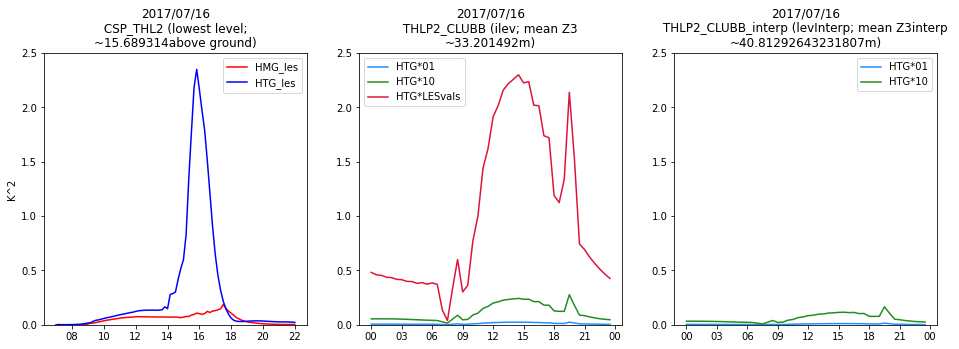

In [32]:
fig,axs=plt.subplots(1,3, figsize=(16,5))
axs    = axs.ravel()

levPlot_LES  = 0
levPlot_SCAM = -1

axs[0].plot(allTimesHMG, HMGds.CSP_THL2.values[:,levPlot_LES],'r-',label='HMG_les')
axs[0].plot(allTimesHTG, HTGds.CSP_THL2.values[:,levPlot_LES],'b-',label='HTG_les')
axs[0].set_ylabel('K^2')
axs[0].legend()

axs[1].plot(HTGpartOnly_times1p0.time.values, 
            np.squeeze(HTGpartOnly_times1p0.isel(ilev=levPlot_SCAM).THLP2_CLUBB.values),
            color='dodgerblue', label='HTG*01')
# axs[1].plot(HTGpartOnly_times5p0.time.values, 
#             np.squeeze(HTGpartOnly_times5p0.isel(ilev=levPlot_SCAM).THLP2_CLUBB.values),
#             color='blueviolet',label='HTG*5')
axs[1].plot(HTGpartOnly_times10p0.time.values, 
            np.squeeze(HTGpartOnly_times10p0.isel(ilev=levPlot_SCAM).THLP2_CLUBB.values),
            color='forestgreen',label='HTG*10')
# axs[1].plot(HTGpartOnly_times100p0.time.values, 
#             np.squeeze(HTGpartOnly_times100p0.isel(ilev=levPlot_SCAM).THLP2_CLUBB.values),
#             color='blueviolet',label='HTG*100')
axs[1].plot(HTGpartOnly_timesLESvals.time.values, 
            np.squeeze(HTGpartOnly_timesLESvals.isel(ilev=levPlot_SCAM).THLP2_CLUBB.values),
            color='crimson',label='HTG*LESvals')

# axs[1].plot(HTGpartOnly_times1p0.time.values, 
#             np.squeeze(HTGpartOnly_times1p0.isel(ilev=levPlot_SCAM).THLP2_CLUBB.values*10),'--',
#             color='limegreen', label='HTG*01 * 10')
# axs[1].plot(HTGpartOnly_times1p0.time.values, 
#             np.squeeze(HTGpartOnly_times1p0.isel(ilev=levPlot_SCAM).THLP2_CLUBB.values*95),'--',
#             color='crimson', label='HTG*01 * 95')

axs[1].legend()


axs[2].plot(HTGpartOnly_times1p0.time.values, 
            np.squeeze(HTGpartOnly_times1p0.isel(levInterp=levPlot_SCAM).THLP2_CLUBB_interp.values),
            color='dodgerblue', label='HTG*01')
# axs[2].plot(HTGpartOnly_times5p0.time.values, 
#             np.squeeze(HTGpartOnly_times5p0.isel(levInterp=levPlot_SCAM).THLP2_CLUBB_interp.values),
#             color='blueviolet',label='HTG*5')
axs[2].plot(HTGpartOnly_times10p0.time.values, 
            np.squeeze(HTGpartOnly_times10p0.isel(levInterp=levPlot_SCAM).THLP2_CLUBB_interp.values),
            color='forestgreen',label='HTG*10')
# axs[2].plot(HTGpartOnly_timesLESvals.time.values, 
#             np.squeeze(HTGpartOnly_timesLESvals.isel(levInterp=levPlot_SCAM).THLP2_CLUBB_interp.values),
#             color='crimson',label='HTG*LESvals')
# axs[2].plot(HTGpartOnly_times100p0.time.values, 
#             np.squeeze(HTGpartOnly_times100p0.isel(ilev=levPlot_SCAM).THLP2_CLUBB.values),
#             color='blueviolet',label='HTG*100')
axs[2].legend()

axs[0].set_title('2017/07/16\n CSP_THL2 (lowest level; \n~'+str(np.mean(meanZ_HMG[levPlot_LES]))+'above ground)')
axs[1].set_title('2017/07/16\n THLP2_CLUBB (ilev; mean Z3 \n~'+str(np.mean(mult_all.sel(case='HMG').Z3.values[:,levPlot_SCAM]))+'m)')
axs[2].set_title('2017/07/16\n THLP2_CLUBB_interp (levInterp; mean Z3interp \n~'+str(np.mean(mult_all.sel(case='HMG').Z3_interp.values[:,levPlot_SCAM]))+'m)')

axs[0].xaxis.set_major_formatter(DateFormatter("%H"))
axs[1].xaxis.set_major_formatter(DateFormatter("%H"))
axs[2].xaxis.set_major_formatter(DateFormatter("%H"))

axs[0].set_ylim([0, 2.5])
axs[1].set_ylim([0, 2.5])
axs[2].set_ylim([0, 2.5])


In [39]:
np.sqrt(95)*np.sqrt(3)

16.88194301613413

(0.0, 1e-06)

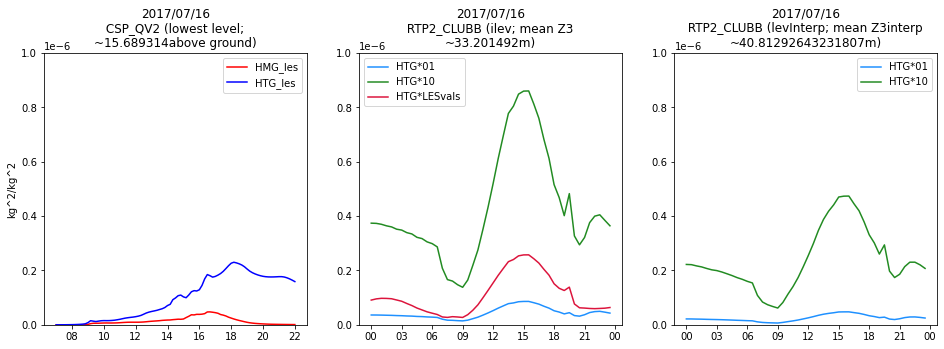

In [33]:
fig,axs=plt.subplots(1,3, figsize=(16,5))
axs    = axs.ravel()

levPlot_LES  = 0
levPlot_SCAM = -1

axs[0].plot(allTimesHMG, HMGds.CSP_QV2.values[:,levPlot_LES],'r-',label='HMG_les')
axs[0].plot(allTimesHTG, HTGds.CSP_QV2.values[:,levPlot_LES],'b-',label='HTG_les')
axs[0].set_ylabel('kg^2/kg^2')
axs[0].legend()

axs[1].plot(HTGpartOnly_times1p0.time.values, 
            np.squeeze(HTGpartOnly_times1p0.isel(ilev=levPlot_SCAM).RTP2_CLUBB.values*(10.0**-6)),
            color='dodgerblue', label='HTG*01')
# axs[1].plot(HTGpartOnly_times5p0.time.values, 
#             np.squeeze(HTGpartOnly_times5p0.isel(ilev=levPlot_SCAM).RTP2_CLUBB.values*(10.0**-6)),
#             color='blueviolet',label='HTG*5')
axs[1].plot(HTGpartOnly_times10p0.time.values, 
            np.squeeze(HTGpartOnly_times10p0.isel(ilev=levPlot_SCAM).RTP2_CLUBB.values*(10.0**-6)),
            color='forestgreen',label='HTG*10')
# axs[1].plot(HTGpartOnly_times100p0.time.values, 
#             np.squeeze(HTGpartOnly_times100p0.isel(ilev=levPlot_SCAM).THLP2_CLUBB.values),
#             color='blueviolet',label='HTG*100')
axs[1].plot(HTGpartOnly_timesLESvals.time.values, 
            np.squeeze(HTGpartOnly_timesLESvals.isel(ilev=levPlot_SCAM).RTP2_CLUBB.values*(10.0**-6)),
            color='crimson',label='HTG*LESvals')
# axs[1].plot(HTGpartOnly_times1p0.time.values, 
#             np.squeeze(HTGpartOnly_times1p0.isel(ilev=levPlot_SCAM).RTP2_CLUBB.values*(10.0**-6)*10),
#             '--', color='limegreen', label='HTG*01 * 10')
# axs[1].plot(HTGpartOnly_times1p0.time.values, 
#             np.squeeze(HTGpartOnly_times1p0.isel(ilev=levPlot_SCAM).RTP2_CLUBB.values*(10.0**-6)*3),
#             '--', color='red', label='HTG*01 * 3')

axs[1].legend()


axs[2].plot(HTGpartOnly_times1p0.time.values, 
            np.squeeze(HTGpartOnly_times1p0.isel(levInterp=levPlot_SCAM).RTP2_CLUBB_interp.values*(10.0**-6)),
            color='dodgerblue', label='HTG*01')
# axs[2].plot(HTGpartOnly_times5p0.time.values, 
#             np.squeeze(HTGpartOnly_times5p0.isel(levInterp=levPlot_SCAM).RTP2_CLUBB_interp.values*(10.0**-6)),
#             color='blueviolet',label='HTG*5')
axs[2].plot(HTGpartOnly_times10p0.time.values, 
            np.squeeze(HTGpartOnly_times10p0.isel(levInterp=levPlot_SCAM).RTP2_CLUBB_interp.values*(10.0**-6)),
            color='forestgreen',label='HTG*10')
# axs[2].plot(HTGpartOnly_times100p0.time.values, 
#             np.squeeze(HTGpartOnly_times100p0.isel(ilev=levPlot_SCAM).THLP2_CLUBB.values),
#             color='blueviolet',label='HTG*100')
axs[2].legend()

axs[0].set_title('2017/07/16\n CSP_QV2 (lowest level; \n~'+str(np.mean(meanZ_HMG[levPlot_LES]))+'above ground)')
axs[1].set_title('2017/07/16\n RTP2_CLUBB (ilev; mean Z3 \n~'+str(np.mean(mult_all.sel(case='HMG').Z3.values[:,levPlot_SCAM]))+'m)')
axs[2].set_title('2017/07/16\n RTP2_CLUBB (levInterp; mean Z3interp \n~'+str(np.mean(mult_all.sel(case='HMG').Z3_interp.values[:,levPlot_SCAM]))+'m)')

axs[0].xaxis.set_major_formatter(DateFormatter("%H"))
axs[1].xaxis.set_major_formatter(DateFormatter("%H"))
axs[2].xaxis.set_major_formatter(DateFormatter("%H"))

axs[0].set_ylim([0, 1.0e-6])
axs[1].set_ylim([0, 1.0e-6])
axs[2].set_ylim([0, 1.0e-6])


### Higher vertical resolution?

In [15]:
archiveDir = '/glade/scratch/mdfowler/archive/'

# dateString = '0615'
# dateString = '0923'
dateString = '0715'

case_mult = ['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMG_256L_start06092016/',
             'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_256L_start06092016/',
             # 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTGens2017_mult5_start'+dateString+'_pert00/', 
             # 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTGens2017_mult10_start'+dateString+'_pert00/',
             # 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTGens2017_mult100_start'+dateString+'_pert00/',
            ]


caseMult_names = ['HMG','HTG*01']

for iCase in range(len(case_mult)): 
    ## Get list of input files 
    listFiles_camh1 = np.sort(glob.glob(archiveDir+case_mult[iCase]+'atm/hist/*cam.h1*'))
    listFiles_camh0 = np.sort(glob.glob(archiveDir+case_mult[iCase]+'atm/hist/*cam.h0*'))
    listFiles_clmh0 = np.sort(glob.glob(archiveDir+case_mult[iCase]+'lnd/hist/*clm2.h0*'))
    
    ## Should only be one file per glob above (ran for two days), so just open each DS here
    iFile = 0 
    with xr.open_dataset(listFiles_camh1[iFile], decode_times=False) as multDS: 
        multDS         = cesm_correct_time(multDS)
        multDS['time'] = multDS.indexes['time'].to_datetimeindex() 

    with xr.open_dataset(listFiles_clmh0[iFile], decode_times=True) as clm_multDS: 
        clm_multDS['time'] = multDS['time']



    ## Add variables as needed (some are on h0 file stream)
    for iVar in range(len(addVars)):
        varMult         = xr.open_dataset(listFiles_camh0[iFile])[addVars[iVar]]
        varMult['time'] = multDS['time']

        multDS = xr.merge([multDS, varMult])

    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (multDS.time.values >= (multDS.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (multDS.time.values <= (multDS.time.values[0] + np.timedelta64(2,'D'))))[0]
    
    multDS      = multDS.isel(time=iTimeStart_day2)
    clm_multDS  = clm_multDS.isel(time=iTimeStart_day2)
    
    ## Give case attribute and combine 
    multDS     = multDS.assign_coords({"case":     caseMult_names[iCase]})
    clm_multDS = clm_multDS.assign_coords({"case": caseMult_names[iCase]})

    if iCase==0: 
        multDS_highRes     = multDS
        clm_multDS_highRes = clm_multDS
    else:
        multDS_highRes     = xr.concat([multDS_highRes,     multDS], "case")
        clm_multDS_highRes = xr.concat([clm_multDS_highRes, clm_multDS], "case")
        
    del multDS,clm_multDS

    print('Read in '+caseMult_names[iCase]+' case')



Read in HMG case
Read in HTG*01 case


In [16]:
## Convert to local times...
# - - - - - - - - - - - - - - 
multDS_highRes_local    = multDS_highRes.copy(deep=True)
clm_multDS_highRes_local= clm_multDS_highRes.copy(deep=True)

# Compute local time 
localTimes = multDS_highRes['time'].values - np.timedelta64(5,'h')

# Replace time dimension with local time
multDS_highRes_local    = multDS_highRes_local.assign_coords({"time": localTimes})
clm_multDS_highRes_local= clm_multDS_highRes_local.assign_coords({"time": localTimes})


In [17]:
def process_camData_highRes(DS):
    ## Add evaporative fraction to DS 
    ds_EF = DS.LHFLX.values / (DS.LHFLX.values + DS.SHFLX.values)
    DS['EvapFraction'] = (('time'), np.squeeze(ds_EF))

    ## Define the actual vertical velocity skew, not just the third order moment 
    skw_W = DS.WP3_CLUBB.values / ((DS.WP2_CLUBB.values)**1.5)
    DS['Skw_W'] = (('time','ilev'), np.squeeze(skw_W))

    ## Add in TKE 
    DS['TKE']  = (('time','ilev','lat,','lon'),
                       0.5*(DS['UP2_CLUBB']+DS['VP2_CLUBB']+DS['WP2_CLUBB'])) 
    DS['TKE'].attrs['units']   = 'm2/s2'
    DS['TKE'].attrs['long_name']   = 'Turbulent Kinetic Energy'
    
    ## Add in wind speed 
    DS['WindMagnitude']  = (('time','lev','lat,','lon'),
                                    np.sqrt((DS.U.values**2.0) + (DS.V.values**2.0)) )

    DS['WindMagnitude'].attrs['units']   = 'm/s'
    DS['WindMagnitude'].attrs['long_name']   = 'Wind speed'
    
    
    ## Compute PBL as max gradient of theta 
    # - - - - - - - - - - - - - - - - - - - - - - - - - - 
    
#     # So first, get actual pressures 
#     p0       = DS['P0'].values[0]
#     plevm    = DS['hyam']*p0 + DS['hybm']*DS['PS'].isel(lat=0,lon=0) # Mid level
#     plevm.attrs['units'] = "Pa"
    
#      # Get *potential* temperature, not just T 
#     theta = np.asarray(mpc.potential_temperature(plevm * units.pascals, DS['T'] * units.kelvin))
#     # Add to existing DS
#     DS['theta'] = (('time','lev','lat','lon'), theta)

#     # Height with standard atmosphere
#     zlevm_vals = 1000.*np.asarray(mpc.pressure_to_height_std(plevm)) # Units of [m] after multiplied 
#     zlevm      = plevm.copy(deep=True)
#     zlevm[:,:] = zlevm_vals

#     # Now compute the BL depth and save it to the larger CAM dataset
#     PBLdepth = PBLHasMaxDZ(DS, 'theta')
#     print('Done computing PBL depth with theta')

#     PBLdepth_qAbs = PBLHasMaxDZ_abs(DS,   'Q')
#     print('Done computing PBL depth with Q')
    
#     # Add above to each dataset
#     DS['PBLdepth']    = (('time'), PBLdepth)
#     DS['PBLdepth_Q']  = (('time'), PBLdepth_qAbs)
    
#     ## Belated realization that the heights computed are above *sea level* not above ground level. 
#     #    Need to subtract elevation. 
#     DS['PBLdepth']   = DS['PBLdepth']  - elevation[0][0] 
#     DS['PBLdepth_Q'] = DS['PBLdepth_Q']  - elevation[0][0] 

    
    ## Interpolate to standard levels 
    # - - - - - - - - - - - - - - - - - - - - - - - -
    print('Beginning interpolation...') 
    
    # Decide on levels to interpoalte to and add to larger arrays
    pnew64 = np.arange(200.0,990.0,2.0) 

    DS = DS.assign_coords({"levInterp": pnew64})

    varSels = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','WPRTP_CLUBB','WPTHLP_CLUBB','WP2_CLUBB','UP2_CLUBB',
                          'VP2_CLUBB','TKE','Z3','U','V','T','Q','OMEGA','RVMTEND_CLUBB','STEND_CLUBB','CLOUD','CLOUDFRAC_CLUBB',
                          'UPWP_CLUBB','WP2RTP_CLUBB','THETAL','WindMagnitude'])

    for iVar in range(len(varSels)): 
        varUnits = DS[varSels[iVar]].units
        varName  = DS[varSels[iVar]].long_name

        # Interpolate variables and add to larger arrays 
        interpVar_real = interpolateToPressure_v2(DS, varSels[iVar], pnew64)

        DS[varSels[iVar]+'_interp']  = (('time','levInterp','lat','lon'), interpVar_real)

        ## Assign attibutes 
        DS[varSels[iVar]+'_interp'].attrs['units']     = varUnits
        DS[varSels[iVar]+'_interp'].attrs['long_name'] = varName

        
    ## Resample to 30m means? 
    DS = DS.resample(time="30Min").mean()
        
    return DS


In [18]:
## Multiplier cases too 
for iCase in range(len(caseMult_names)):
    sel_mult = process_camData_highRes( multDS_highRes_local.sel(case=caseMult_names[iCase]) )
    
    if iCase==0: 
        mult_highRes = sel_mult
    else:
        mult_highRes = xr.concat([mult_highRes, sel_mult], "case")

    del sel_mult
    

Beginning interpolation...
Beginning interpolation...


In [19]:
HTGpartOnly_highRes   = mult_highRes.sel(case='HTG*01')  - mult_highRes.sel(case='HMG')


(0.0, 2.5)

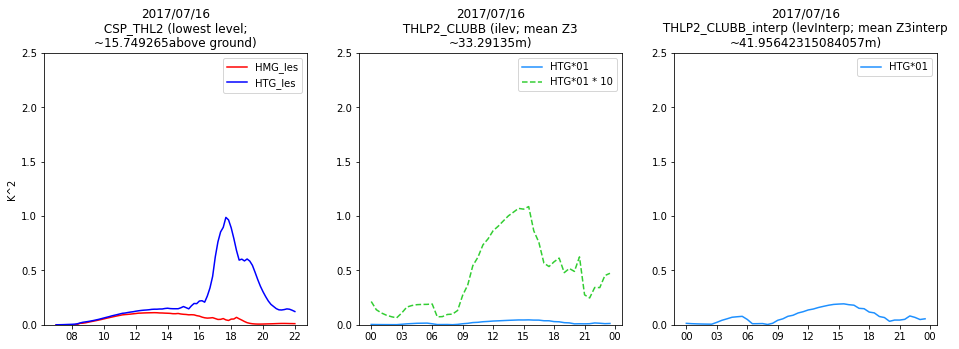

In [21]:
fig,axs=plt.subplots(1,3, figsize=(16,5))
axs    = axs.ravel()

levPlot_LES  = 0
levPlot_SCAM = -1

axs[0].plot(allTimesHMG, HMGds.CSP_THL2.values[:,levPlot_LES],'r-',label='HMG_les')
axs[0].plot(allTimesHTG, HTGds.CSP_THL2.values[:,levPlot_LES],'b-',label='HTG_les')
axs[0].set_ylabel('K^2')
axs[0].legend()

axs[1].plot(HTGpartOnly_highRes.time.values, 
            np.squeeze(HTGpartOnly_highRes.isel(ilev=levPlot_SCAM).THLP2_CLUBB.values),
            color='dodgerblue', label='HTG*01')
axs[1].plot(HTGpartOnly_times1p0.time.values, 
            np.squeeze(HTGpartOnly_times1p0.isel(ilev=levPlot_SCAM).THLP2_CLUBB.values*10),'--',
            color='limegreen', label='HTG*01 * 10')
axs[1].legend()


axs[2].plot(HTGpartOnly_highRes.time.values, 
            np.squeeze(HTGpartOnly_highRes.isel(levInterp=levPlot_SCAM).THLP2_CLUBB_interp.values),
            color='dodgerblue', label='HTG*01')

axs[2].legend()

axs[0].set_title('2017/07/16\n CSP_THL2 (lowest level; \n~'+str(np.mean(meanZ_HMG[levPlot_LES]))+'above ground)')
axs[1].set_title('2017/07/16\n THLP2_CLUBB (ilev; mean Z3 \n~'+str(np.mean(mult_all.sel(case='HMG').Z3.values[:,levPlot_SCAM]))+'m)')
axs[2].set_title('2017/07/16\n THLP2_CLUBB_interp (levInterp; mean Z3interp \n~'+str(np.mean(mult_all.sel(case='HMG').Z3_interp.values[:,levPlot_SCAM]))+'m)')

axs[0].xaxis.set_major_formatter(DateFormatter("%H"))
axs[1].xaxis.set_major_formatter(DateFormatter("%H"))
axs[2].xaxis.set_major_formatter(DateFormatter("%H"))

axs[0].set_ylim([0, 2.5])
axs[1].set_ylim([0, 2.5])
axs[2].set_ylim([0, 2.5])


(0.0, 1e-06)

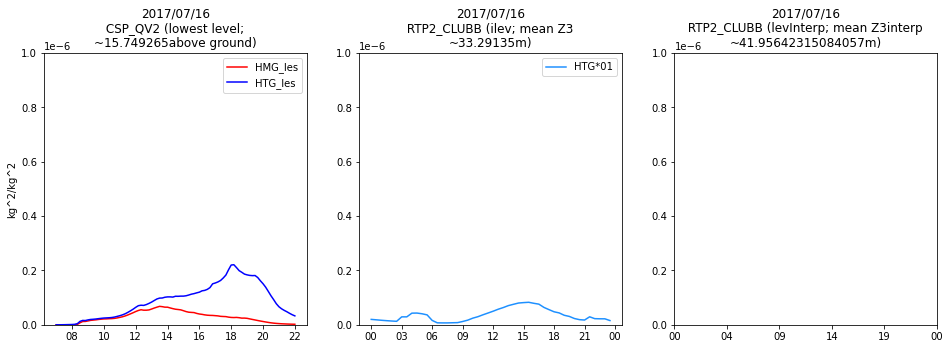

In [22]:
fig,axs=plt.subplots(1,3, figsize=(16,5))
axs    = axs.ravel()

levPlot_LES  = 0
levPlot_SCAM = -1

axs[0].plot(allTimesHMG, HMGds.CSP_QV2.values[:,levPlot_LES],'r-',label='HMG_les')
axs[0].plot(allTimesHTG, HTGds.CSP_QV2.values[:,levPlot_LES],'b-',label='HTG_les')
axs[0].set_ylabel('kg^2/kg^2')
axs[0].legend()

axs[1].plot(HTGpartOnly_highRes.time.values, 
            np.squeeze(HTGpartOnly_highRes.isel(ilev=levPlot_SCAM).RTP2_CLUBB.values*(10.0**-6)),
            color='dodgerblue', label='HTG*01')
axs[1].legend()



axs[0].set_title('2017/07/16\n CSP_QV2 (lowest level; \n~'+str(np.mean(meanZ_HMG[levPlot_LES]))+'above ground)')
axs[1].set_title('2017/07/16\n RTP2_CLUBB (ilev; mean Z3 \n~'+str(np.mean(mult_all.sel(case='HMG').Z3.values[:,levPlot_SCAM]))+'m)')
axs[2].set_title('2017/07/16\n RTP2_CLUBB (levInterp; mean Z3interp \n~'+str(np.mean(mult_all.sel(case='HMG').Z3_interp.values[:,levPlot_SCAM]))+'m)')

axs[0].xaxis.set_major_formatter(DateFormatter("%H"))
axs[1].xaxis.set_major_formatter(DateFormatter("%H"))
axs[2].xaxis.set_major_formatter(DateFormatter("%H"))

axs[0].set_ylim([0, 1.0e-6])
axs[1].set_ylim([0, 1.0e-6])
axs[2].set_ylim([0, 1.0e-6])


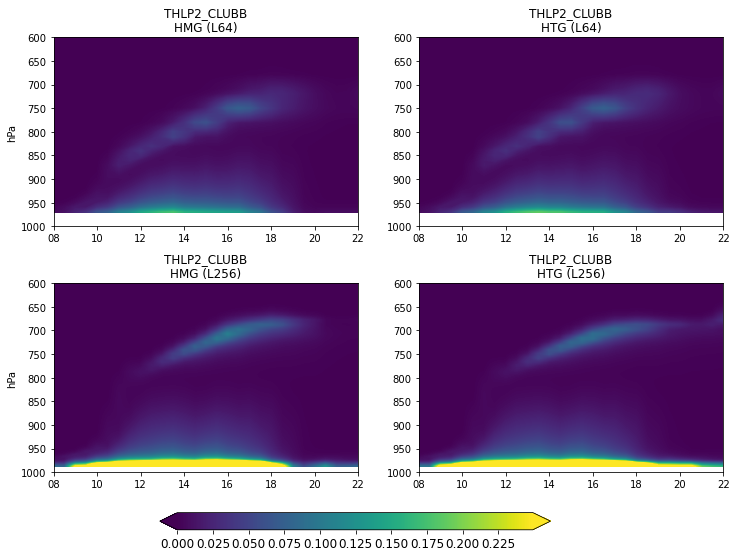

In [27]:
fig,axs = plt.subplots(2,2, figsize=(12,8))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.3)

## Plot HMG and the original HTG case 
levsc = np.arange(0.0,0.25,0.001)

axs[0].contourf(mult_all.sel(case='HMG').time.values, 
                mult_all.sel(case='HMG').levInterp.values, 
                np.squeeze(mult_all.sel(case='HMG').THLP2_CLUBB_interp.values).transpose(),
                levsc, extend='both' )

axs[1].contourf(mult_all.sel(case='HTG*01').time.values, 
                       mult_all.sel(case='HTG*01').levInterp.values, 
                       np.squeeze(mult_all.sel(case='HTG*01').THLP2_CLUBB_interp.values).transpose(),
                levsc, extend='both' )



axs[2].contourf(mult_highRes.sel(case='HMG').time.values, 
                mult_highRes.sel(case='HMG').levInterp.values, 
                np.squeeze(mult_highRes.sel(case='HMG').THLP2_CLUBB_interp.values).transpose(),
                levsc, extend='both' )

c3=axs[3].contourf(mult_highRes.sel(case='HTG*01').time.values, 
                mult_highRes.sel(case='HTG*01').levInterp.values, 
                np.squeeze(mult_highRes.sel(case='HTG*01').THLP2_CLUBB_interp.values).transpose(),
                levsc, extend='both' )

axs[0].set_ylabel('hPa') 
axs[2].set_ylabel('hPa') 

axs[0].set_title('THLP2_CLUBB'+'\nHMG (L64)')
axs[1].set_title('THLP2_CLUBB'+'\nHTG (L64)')
axs[2].set_title('THLP2_CLUBB'+'\nHMG (L256)')
axs[3].set_title('THLP2_CLUBB'+'\nHTG (L256)')

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()

axs[0].set_ylim([1000,600])
axs[1].set_ylim([1000,600])
axs[2].set_ylim([1000,600])
axs[3].set_ylim([1000,600])

axs[0].set_xlim([mult_highRes.sel(case='HMG').time.values[16], mult_highRes.sel(case='HMG').time.values[-4]])
axs[1].set_xlim([mult_highRes.sel(case='HMG').time.values[16], mult_highRes.sel(case='HMG').time.values[-4]])
axs[2].set_xlim([mult_highRes.sel(case='HMG').time.values[16], mult_highRes.sel(case='HMG').time.values[-4]])
axs[3].set_xlim([mult_highRes.sel(case='HMG').time.values[16], mult_highRes.sel(case='HMG').time.values[-4]])


axs[0].xaxis.set_major_formatter(DateFormatter("%H"))
axs[1].xaxis.set_major_formatter(DateFormatter("%H"))
axs[2].xaxis.set_major_formatter(DateFormatter("%H"))
axs[3].xaxis.set_major_formatter(DateFormatter("%H"))

# Add colorbar
ax_position = axs[3].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.3, ax_position.y0-0.1, ax_position.width+0.1, 0.03])
cbar = plt.colorbar(c3, orientation='horizontal',cax=cbar_ax)
cbar.ax.tick_params(labelsize=12)  


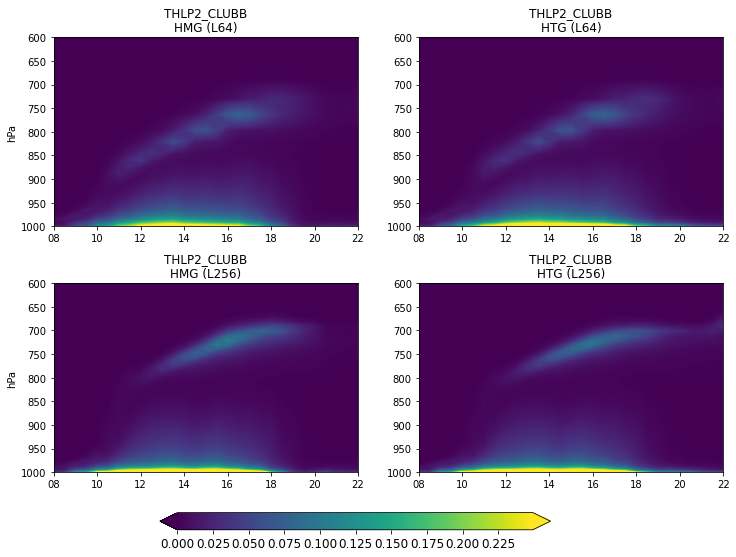

In [26]:
fig,axs = plt.subplots(2,2, figsize=(12,8))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.3)

## Plot HMG and the original HTG case 
levsc = np.arange(0.0,0.25,0.001)

axs[0].contourf(mult_all.sel(case='HMG').time.values, 
                mult_all.sel(case='HMG').ilev.values, 
                np.squeeze(mult_all.sel(case='HMG').THLP2_CLUBB.values).transpose(),
                levsc, extend='both' )

axs[1].contourf(mult_all.sel(case='HTG*01').time.values, 
                       mult_all.sel(case='HTG*01').ilev.values, 
                       np.squeeze(mult_all.sel(case='HTG*01').THLP2_CLUBB.values).transpose(),
                levsc, extend='both' )



axs[2].contourf(mult_highRes.sel(case='HMG').time.values, 
                mult_highRes.sel(case='HMG').ilev.values, 
                np.squeeze(mult_highRes.sel(case='HMG').THLP2_CLUBB.values).transpose(),
                levsc, extend='both' )

c3=axs[3].contourf(mult_highRes.sel(case='HTG*01').time.values, 
                mult_highRes.sel(case='HTG*01').ilev.values, 
                np.squeeze(mult_highRes.sel(case='HTG*01').THLP2_CLUBB.values).transpose(),
                levsc, extend='both' )

axs[0].set_ylabel('hPa') 
axs[2].set_ylabel('hPa') 

axs[0].set_title('THLP2_CLUBB'+'\nHMG (L64)')
axs[1].set_title('THLP2_CLUBB'+'\nHTG (L64)')
axs[2].set_title('THLP2_CLUBB'+'\nHMG (L256)')
axs[3].set_title('THLP2_CLUBB'+'\nHTG (L256)')

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()

axs[0].set_ylim([1000,600])
axs[1].set_ylim([1000,600])
axs[2].set_ylim([1000,600])
axs[3].set_ylim([1000,600])

axs[0].set_xlim([mult_highRes.sel(case='HMG').time.values[16], mult_highRes.sel(case='HMG').time.values[-4]])
axs[1].set_xlim([mult_highRes.sel(case='HMG').time.values[16], mult_highRes.sel(case='HMG').time.values[-4]])
axs[2].set_xlim([mult_highRes.sel(case='HMG').time.values[16], mult_highRes.sel(case='HMG').time.values[-4]])
axs[3].set_xlim([mult_highRes.sel(case='HMG').time.values[16], mult_highRes.sel(case='HMG').time.values[-4]])


axs[0].xaxis.set_major_formatter(DateFormatter("%H"))
axs[1].xaxis.set_major_formatter(DateFormatter("%H"))
axs[2].xaxis.set_major_formatter(DateFormatter("%H"))
axs[3].xaxis.set_major_formatter(DateFormatter("%H"))

# Add colorbar
ax_position = axs[3].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.3, ax_position.y0-0.1, ax_position.width+0.1, 0.03])
cbar = plt.colorbar(c3, orientation='horizontal',cax=cbar_ax)
cbar.ax.tick_params(labelsize=12)  


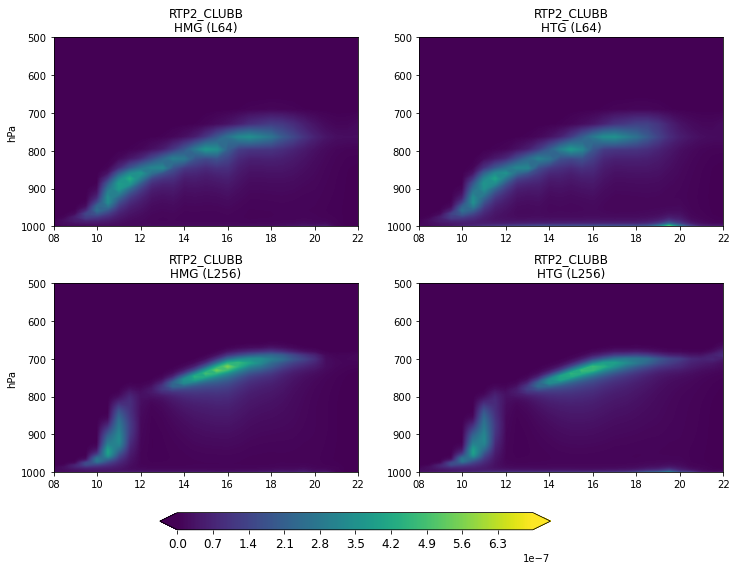

In [35]:
fig,axs = plt.subplots(2,2, figsize=(12,8))
axs     = axs.ravel()
fig.subplots_adjust(hspace=0.3)

## Plot HMG and the original HTG case 
levsc = np.arange(0.0,7e-7,0.01e-7)

axs[0].contourf(mult_all.sel(case='HMG').time.values, 
                mult_all.sel(case='HMG').ilev.values, 
                np.squeeze(mult_all.sel(case='HMG').RTP2_CLUBB.values*(10.0**-6)).transpose(),
                levsc, extend='both' )

axs[1].contourf(mult_all.sel(case='HTG*01').time.values, 
                       mult_all.sel(case='HTG*01').ilev.values, 
                       np.squeeze(mult_all.sel(case='HTG*01').RTP2_CLUBB.values*(10.0**-6)).transpose(),
                levsc, extend='both' )



axs[2].contourf(mult_highRes.sel(case='HMG').time.values, 
                mult_highRes.sel(case='HMG').ilev.values, 
                np.squeeze(mult_highRes.sel(case='HMG').RTP2_CLUBB.values*(10.0**-6)).transpose(),
                levsc, extend='both' )

c3=axs[3].contourf(mult_highRes.sel(case='HTG*01').time.values, 
                mult_highRes.sel(case='HTG*01').ilev.values, 
                np.squeeze(mult_highRes.sel(case='HTG*01').RTP2_CLUBB.values*(10.0**-6)).transpose(),
                levsc, extend='both' )

axs[0].set_ylabel('hPa') 
axs[2].set_ylabel('hPa') 

axs[0].set_title('RTP2_CLUBB'+'\nHMG (L64)')
axs[1].set_title('RTP2_CLUBB'+'\nHTG (L64)')
axs[2].set_title('RTP2_CLUBB'+'\nHMG (L256)')
axs[3].set_title('RTP2_CLUBB'+'\nHTG (L256)')

axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()

axs[0].set_ylim([1000,500])
axs[1].set_ylim([1000,500])
axs[2].set_ylim([1000,500])
axs[3].set_ylim([1000,500])

axs[0].set_xlim([mult_highRes.sel(case='HMG').time.values[16], mult_highRes.sel(case='HMG').time.values[-4]])
axs[1].set_xlim([mult_highRes.sel(case='HMG').time.values[16], mult_highRes.sel(case='HMG').time.values[-4]])
axs[2].set_xlim([mult_highRes.sel(case='HMG').time.values[16], mult_highRes.sel(case='HMG').time.values[-4]])
axs[3].set_xlim([mult_highRes.sel(case='HMG').time.values[16], mult_highRes.sel(case='HMG').time.values[-4]])


axs[0].xaxis.set_major_formatter(DateFormatter("%H"))
axs[1].xaxis.set_major_formatter(DateFormatter("%H"))
axs[2].xaxis.set_major_formatter(DateFormatter("%H"))
axs[3].xaxis.set_major_formatter(DateFormatter("%H"))

# Add colorbar
ax_position = axs[3].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.3, ax_position.y0-0.1, ax_position.width+0.1, 0.03])
cbar = plt.colorbar(c3, orientation='horizontal',cax=cbar_ax)
cbar.ax.tick_params(labelsize=12)  


## Default LES data 

In [59]:
varSels = np.asarray(['AVT_T2','AVT_Q2','AVT_LWP',
                      'AVV_LWC','AVV_QV','AVV_QC','AVV_THV','AVV_TH',
                      'AVP_LWC','AVP_QV','AVP_QC',
                      'AVS_LWP','AVS_RAIN','AVS_LH','AVS_SH','AVS_Q2','AVS_T2',
                      ,'XTIME'])

In [60]:
lesDir = '/glade/work/mdfowler/CLASP/LESdata_fromJason/defaultOutput/chaney-web-00.egr.duke.edu/CLASP/LES/diags/'

HMGdir = lesDir+'doz_20170716_01/'
HTGdir = lesDir+'doz_20170716_00/'

listFilesHMG = np.sort(glob.glob(HMGdir+'diag_d01*'))
listFilesHTG = np.sort(glob.glob(HTGdir+'diag_d01*'))

for iFileHMG in range(len(listFilesHMG)): 
    dsHMG = xr.open_dataset(listFilesHMG[iFileHMG], decode_times=False)[varSels]
    dsHMG = dsHMG.set_index(Time='XTIME') 

    if iFileHMG==0:
        HMGds_lesDay = dsHMG 
    else: 
        HMGds_lesDay = xr.concat([HMGds_lesDay, dsHMG], dim='Time')
        
    # print(dsHMG.START_DATE)
    # print('Starting, ending XTIME: ', dsHMG.Time.values[0], dsHMG.Time.values[-1])

    print('Done with file %i of %i' % (iFileHMG, len(listFilesHMG)) )
    

Done with file 0 of 11
Done with file 1 of 11
Done with file 2 of 11
Done with file 3 of 11
Done with file 4 of 11
Done with file 5 of 11
Done with file 6 of 11
Done with file 7 of 11
Done with file 8 of 11
Done with file 9 of 11
Done with file 10 of 11


In [61]:
## I am purposefully only reading in files to the length of listFilesHMG - there are more in HTG, but I'd like an even set of data

for iFileHTG in range(len(listFilesHMG)): 
    dsHTG = xr.open_dataset(listFilesHTG[iFileHTG], decode_times=False)[varSels]
    dsHTG = dsHTG.set_index(Time='XTIME') 

    if iFileHTG==0:
        HTGds_lesDay = dsHTG 
    else: 
        HTGds_lesDay = xr.concat([HTGds_lesDay, dsHTG], dim='Time')

    print('Done with file %i of %i' % (iFileHTG, len(listFilesHTG)) )

Done with file 0 of 11
Done with file 1 of 11
Done with file 2 of 11
Done with file 3 of 11
Done with file 4 of 11
Done with file 5 of 11
Done with file 6 of 11
Done with file 7 of 11
Done with file 8 of 11
Done with file 9 of 11
Done with file 10 of 11


In [62]:
startTime   = datetime.datetime(2017,7,16, (12-5), 0, 0)  ## Starts at 12 UTC, so -5hr to get to LST

timesHMG = [] 
timesHTG = [] 

for iT in range(len(HMGds_lesDay.Time.values)): 
    timeStep = startTime+timedelta(minutes = int(HMGds_lesDay.Time.values[iT]))
    timesHMG = np.append(timesHMG, timeStep)
    
for iT in range(len(HTGds_lesDay.Time.values)): 
    timeStep = startTime+timedelta(minutes = int(HTGds_lesDay.Time.values[iT]))
    timesHTG = np.append(timesHTG, timeStep)
    
HMGds_lesDay['datetime'] = (('Time'), timesHMG)
HMGds_lesDay              = HMGds_lesDay.set_index(Time='datetime')

HTGds_lesDay['datetime'] = (('Time'), timesHTG)
HTGds_lesDay              = HTGds_lesDay.set_index(Time='datetime')



In [63]:
print(HMGds_lesDay.Time.values)

['2017-07-16T07:00:00.000000000' '2017-07-16T08:00:00.000000000'
 '2017-07-16T09:00:00.000000000' '2017-07-16T10:00:00.000000000'
 '2017-07-16T11:00:00.000000000' '2017-07-16T12:00:00.000000000'
 '2017-07-16T13:00:00.000000000' '2017-07-16T14:00:00.000000000'
 '2017-07-16T15:00:00.000000000' '2017-07-16T16:00:00.000000000'
 '2017-07-16T17:00:00.000000000']


### Plot timeseries?

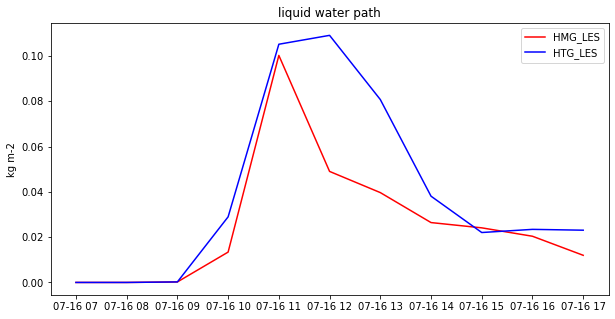

In [85]:
fig,axs = plt.subplots(1,1, figsize=(10,5))

axs.plot(HMGds_lesDay.Time.values, HMGds_lesDay.AVT_LWP.values,'r', label='HMG_LES')
axs.plot(HTGds_lesDay.Time.values, HTGds_lesDay.AVT_LWP.values,'b', label='HTG_LES')
axs.set_title(HMGds_lesDay.AVT_LWP.description)
axs.set_ylabel(HMGds_lesDay.AVT_LWP.units)
axs.legend()


Text(0, 0.5, 'kg/m2')

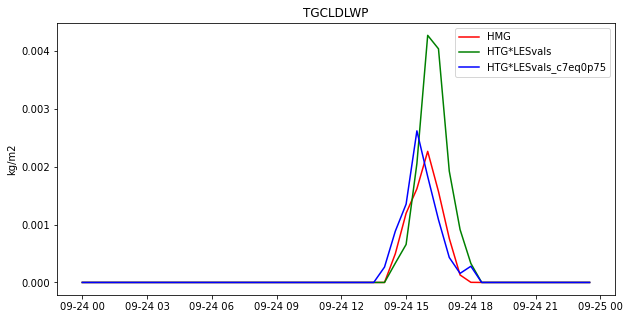

In [48]:
fig,axs = plt.subplots(1,1, figsize=(10,5))
# axs = axs.ravel()

axs.plot(mult_all.sel(case='HMG').time.values,
         np.squeeze(mult_all.sel(case='HMG').TGCLDLWP.values), 'r', label='HMG')

axs.plot(mult_all.sel(case='HTG*LESvals').time.values,
         np.squeeze(mult_all.sel(case='HTG*LESvals').TGCLDLWP.values), 'g', label='HTG*LESvals')

axs.plot(mult_all.sel(case='HTG*LESvals_c7eq0p75').time.values,
         np.squeeze(mult_all.sel(case='HTG*LESvals_c7eq0p75').TGCLDLWP.values), 'b', label='HTG*LESvals_c7eq0p75')

axs.legend()

axs.set_title('TGCLDLWP')
axs.set_ylabel(multDS_allCases.TGCLDLWP.units)


Text(0, 0.5, 'fraction')

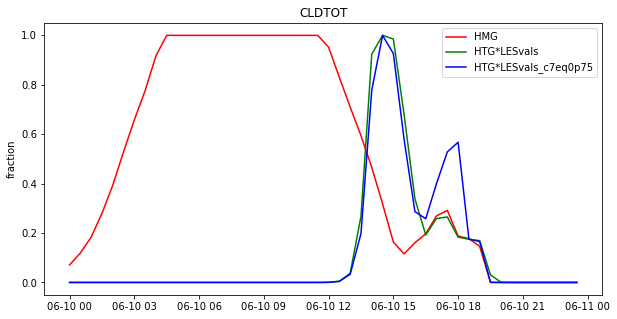

In [10]:
fig,axs = plt.subplots(1,1, figsize=(10,5))
# axs = axs.ravel()

plotVar = 'CLDTOT'

axs.plot(mult_all.sel(case='HMG').time.values,
         np.squeeze(mult_all.sel(case='HMG')[plotVar].values), 'r', label='HMG')

axs.plot(mult_all.sel(case='HTG*LESvals').time.values,
         np.squeeze(mult_all.sel(case='HTG*LESvals')[plotVar].values), 'g', label='HTG*LESvals')

axs.plot(mult_all.sel(case='HTG*LESvals_c7eq0p75').time.values,
         np.squeeze(mult_all.sel(case='HTG*LESvals_c7eq0p75')[plotVar].values), 'b', label='HTG*LESvals_c7eq0p75')

axs.legend()
axs.set_title(plotVar)
axs.set_ylabel(multDS_allCases_local[plotVar].units)


### Animate evolution in each case?

In [12]:
xvals = HMGds_lesDay.west_east.values
yvals = HMGds_lesDay.south_north.values

Text(0.5, 1.0, 'HTG-HMG: surface sensible heat flux\n7/16: Local Hour 10')

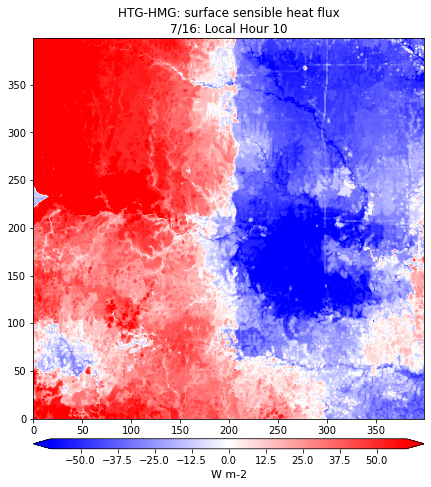

In [56]:
# fig,axs = plt.subplots(3,2, figsize=(10,10), subplot_kw={'projection':ccrs.PlateCarree()})
fig,axs = plt.subplots(1,1, figsize=(7,7))

pltVar  = 'AVS_SH'
timeSel = 3

levsC = np.arange(-60, 60.5, 0.5)

cplot=axs.contourf(xvals, yvals, HTGds_lesDay.isel(Time=timeSel)[pltVar].values - HMGds_lesDay.isel(Time=timeSel)[pltVar].values,
             levsC, cmap='bwr', extend='both')

## Add colorbar
ax_position = axs.get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.06, ax_position.width, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)
cbar.set_label(dsHMG[pltVar].units,fontsize=11)

axs.set_title('HTG-HMG: '+dsHMG[pltVar].description+'\n'+
              str(HMGds_lesDay['Time.month'].values[timeSel])+'/'+
              str(HMGds_lesDay['Time.day'].values[timeSel])+': Local Hour '+
              str(HMGds_lesDay['Time.hour'].values[timeSel]) )



Text(0.5, 1.0, 'HTG-HMG: rain at surface\n7/16: Local Hour 13')

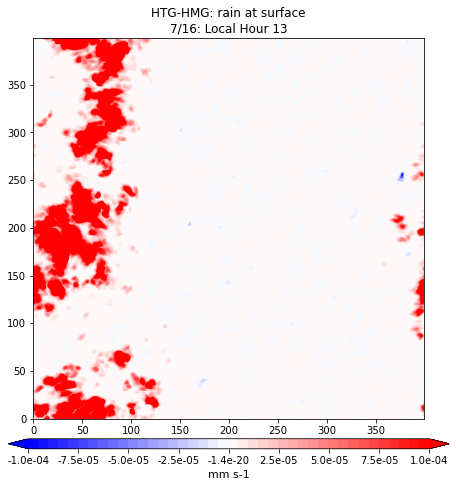

In [68]:
# fig,axs = plt.subplots(3,2, figsize=(10,10), subplot_kw={'projection':ccrs.PlateCarree()})
fig,axs = plt.subplots(1,1, figsize=(7,7))

pltVar  = 'AVS_RAIN'
timeSel = 6

levsC = np.arange(-1e-4, 1.05e-4, 0.05e-4)

cplot=axs.contourf(xvals, yvals, HTGds_lesDay.isel(Time=timeSel)[pltVar].values - HMGds_lesDay.isel(Time=timeSel)[pltVar].values,
             levsC, cmap='bwr', extend='both')

## Add colorbar
ax_position = axs.get_position()
cbar_ax     = fig.add_axes([ax_position.x0-0.05, ax_position.y0-0.06, ax_position.width+0.1, 0.02])
cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax, format='%.1e')
cbar.set_label(dsHMG[pltVar].units,fontsize=11)

axs.set_title('HTG-HMG: '+dsHMG[pltVar].description+'\n'+
              str(HMGds_lesDay['Time.month'].values[timeSel])+'/'+
              str(HMGds_lesDay['Time.day'].values[timeSel])+': Local Hour '+
              str(HMGds_lesDay['Time.hour'].values[timeSel]) )


In [13]:
def drawMap(pltVar, timeSel, levsC):
    cplot=axs.contourf(xvals, yvals, HTGds_lesDay.isel(Time=timeSel)[pltVar].values - HMGds_lesDay.isel(Time=timeSel)[pltVar].values,
             levsC, cmap='bwr', extend='both')

    ## Add colorbar
    if timeSel==0:
        ax_position = axs.get_position()
        cbar_ax     = fig.add_axes([ax_position.x0-0.05, ax_position.y0-0.06, ax_position.width+0.1, 0.02])
        cbar        = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax, format='%.1e')
        cbar.set_label(dsHMG[pltVar].units,fontsize=11)

    axs.set_title('HTG-HMG: '+dsHMG[pltVar].description+'\n'+
                  str(HMGds_lesDay['Time.month'].values[timeSel])+'/'+
                  str(HMGds_lesDay['Time.day'].values[timeSel])+': Local Hour '+
                  str(HMGds_lesDay['Time.hour'].values[timeSel]) )


    return

def animate(frame):
    return drawMap(pltVar, frame, levsC)


In [22]:
fig,axs = plt.subplots(1,1, figsize=(7,7))

pltVar  = 'AVS_RAIN'
levsC = np.arange(-1e-4, 1.05e-4, 0.05e-4)
frames = len(HMGds_lesDay.Time.values)

ani = animation.FuncAnimation(fig, animate, frames, interval=1, blit=False,
                            repeat=False)

# ani.save('TestAnimation_HTGminusHMG_'+pltVar+'.mp4', writer=animation.FFMpegWriter(fps=8))
writergif = animation.PillowWriter(fps=1) 
ani.save('../CLASP_animations/20170716_HTGminusHMG_'+pltVar+'.gif', writer=writergif)

plt.close(fig)